# Nurse Stress - Analiza ML

## Cel:
**Kompletna analiza danych Nurse** z użyciem Machine Learning:
- Wczytanie zmergowanego CSV
- Przygotowanie danych i etykiet
- Trening modeli ML (RandomForest, GradientBoosting, LogisticRegression, ExtraTrees)
- Ewaluacja i wizualizacja
- Streamlit app

**Dane:** Zmergowany CSV z danymi Nurse (`nurse_features.csv` lub `merged_data.csv`)


## KROK 1: Imports i Konfiguracja


In [53]:
# 🔹 IMPORTS I KONFIGURACJA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# ML
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)
from sklearn.decomposition import PCA

# Konfiguracja
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Ścieżki
notebook_dir = Path.cwd()
results_dir = notebook_dir.parent / 'results'
if not results_dir.exists():
    results_dir = notebook_dir / 'results'
if not results_dir.exists():
    results_dir = Path("../results")
if not results_dir.exists():
    results_dir.mkdir(parents=True, exist_ok=True)

print(f"📁 Results dir: {results_dir}")

# Wizualizacja
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline


📁 Results dir: /Users/turfian/Downloads/archive (4)/WESAD/wesad-prep/nurse-stress-analysis/results


## KROK 2: Wczytaj dane Nurse

**Uwaga:** Jeśli masz surowe sygnały (EDA, HR, TEMP), najpierw uruchom KROK 2.5 (wyciąganie cech fizjologicznych).


In [54]:
# 🔹 WCZYTAJ DANE NURSE
print("=" * 80)
print("WCZYTYWANIE DANYCH NURSE")
print("=" * 80)

# Spróbuj różne lokalizacje
nurse_files = [
    results_dir / 'nurse_features.csv',
    results_dir / 'merged_data.csv',
    Path("../results/nurse_features.csv"),
    Path("../results/merged_data.csv"),
]

df_nurse = None
for file_path in nurse_files:
    if file_path.exists():
        print(f"\n📁 Znaleziono: {file_path}")
        try:
            df_nurse = pd.read_csv(file_path)
            print(f"   ✅ Wczytano: {df_nurse.shape}")
            print(f"   Kolumny: {list(df_nurse.columns[:10])}...")
            break
        except Exception as e:
            print(f"   ❌ Błąd wczytywania: {e}")
            continue

if df_nurse is None:
    print("\n❌ Nie znaleziono danych Nurse!")
    print("   Sprawdź czy plik istnieje w jednej z lokalizacji:")
    for f in nurse_files:
        print(f"      - {f}")
else:
    print(f"\n✅ Dane wczytane pomyślnie!")
    print(f"   Rozmiar: {df_nurse.shape}")
    print(f"   Braki: {df_nurse.isna().sum().sum()} wartości")
    
    # Zapisz do globals
    globals()['df_nurse'] = df_nurse


WCZYTYWANIE DANYCH NURSE

📁 Znaleziono: /Users/turfian/Downloads/archive (4)/WESAD/wesad-prep/nurse-stress-analysis/results/nurse_features.csv
   ✅ Wczytano: (2271, 87)
   Kolumny: ['EDA_mean', 'EDA_std', 'EDA_max', 'EDA_min', 'EDA_auc', 'EDA_slope', 'EDA_peak_count', 'EDA_latency', 'HR_mean', 'HR_std']...

✅ Dane wczytane pomyślnie!
   Rozmiar: (2271, 87)
   Braki: 0 wartości


## KROK 2.5: Wyciągnij cechy fizjologiczne (piki, latencja, czas trwania)

**Cel:** Wyciągnij cechy podobne do WESAD: piki, latencja, czas trwania reakcji, AUC, slope.


In [55]:
# 🔹 WYCIĄGNIJ CECHY FIZJOLOGICZNE (Piki, Latencja, Czas trwania)
print("=" * 80)
print("WYCIĄGANIE CECH FIZJOLOGICZNYCH (jak w WESAD)")
print("=" * 80)

from scipy import signal
from scipy.stats import skew, kurtosis

def detect_peaks(signal_data, fs=1.0, min_distance=None, prominence=None):
    """Wykrywa piki w sygnale"""
    # Sprawdź długość sygnału
    if len(signal_data) == 0:
        return np.array([])
    
    # Konwertuj na numpy array jeśli potrzeba
    signal_data = np.asarray(signal_data, dtype=np.float64)
    
    # Sprawdź i usuń NaN/inf
    if np.any(np.isnan(signal_data)) or np.any(np.isinf(signal_data)):
        # Wypełnij NaN/inf interpolacją lub medianą
        mask = np.isfinite(signal_data)
        if mask.sum() == 0:
            return np.array([])  # Wszystkie wartości są NaN/inf
        
        if mask.sum() < len(signal_data):
            # Interpoluj brakujące wartości
            signal_data = np.interp(
                np.arange(len(signal_data)),
                np.arange(len(signal_data))[mask],
                signal_data[mask]
            )
    
    # Sprawdź długość po czyszczeniu
    if len(signal_data) < 3:
        return np.array([])
    
    # Oblicz min_distance (musi być >= 1)
    if min_distance is None:
        min_distance = max(1, int(fs * 0.5))  # Minimum 0.5s między peakami
    else:
        min_distance = max(1, int(min_distance))
    
    # Oblicz prominence (musi być > 0)
    if prominence is None:
        std_val = np.std(signal_data)
        if std_val > 0 and not np.isnan(std_val):
            prominence = std_val * 0.3  # 30% odchylenia standardowego
        else:
            # Fallback: użyj 1% zakresu sygnału
            signal_range = np.max(signal_data) - np.min(signal_data)
            prominence = max(0.01, signal_range * 0.01)
    else:
        prominence = max(0.01, float(prominence))
    
    # Zabezpiecz distance - nie może być większe niż długość sygnału
    min_distance = min(min_distance, len(signal_data) - 1)
    
    try:
        peaks, properties = signal.find_peaks(
            signal_data, 
            distance=min_distance, 
            prominence=prominence
        )
        return peaks
    except Exception as e:
        # Fallback: prostsze wykrywanie pików
        try:
            peaks, _ = signal.find_peaks(
                signal_data,
                distance=max(1, len(signal_data) // 20),  # Minimum 5% długości
                height=np.percentile(signal_data, 75)  # 75 percentyl
            )
            return peaks
        except:
            return np.array([])

def compute_latency(signal_data, peaks, fs=1.0):
    """Oblicza latencję (czas do pierwszego piku)"""
    if len(peaks) == 0:
        return np.nan
    return peaks[0] / fs  # Czas do pierwszego piku w sekundach

def compute_reaction_duration(signal_data, peaks, fs=1.0):
    """Oblicza czas trwania reakcji (od pierwszego do ostatniego piku)"""
    if len(peaks) < 2:
        return np.nan
    return (peaks[-1] - peaks[0]) / fs  # Czas trwania w sekundach

def compute_auc(signal_data, baseline=None):
    """Oblicza AUC (pole pod krzywą)"""
    if baseline is None:
        baseline = np.min(signal_data)
    # AUC jako suma różnic od baseline
    return np.sum(np.maximum(signal_data - baseline, 0))

def compute_slope(signal_data):
    """Oblicza slope (nachylenie trendu)"""
    if len(signal_data) < 2:
        return 0.0
    x = np.arange(len(signal_data))
    coeffs = np.polyfit(x, signal_data, 1)
    return coeffs[0]

def compute_rmssd(signal_data):
    """Oblicza RMSSD (dla HRV)"""
    if len(signal_data) < 2:
        return 0.0
    diff = np.diff(signal_data)
    return np.sqrt(np.mean(diff**2))

def compute_tonic_level(signal_data):
    """Oblicza poziom toniczny (podstawowy poziom przewodnictwa) - percentyl 10"""
    if len(signal_data) < 1:
        return np.nan
    return np.percentile(signal_data, 10)

def detect_scr_responses(signal_data, fs=1.0, min_amplitude=None, min_rise_time=0.5):
    """Wykrywa reakcje skórne (SCR - Skin Conductance Responses) - phasic responses"""
    # Sprawdź długość sygnału
    if len(signal_data) == 0:
        return []
    
    # Konwertuj na numpy array jeśli potrzeba
    signal_data = np.asarray(signal_data, dtype=np.float64)
    
    # Sprawdź i usuń NaN/inf
    if np.any(np.isnan(signal_data)) or np.any(np.isinf(signal_data)):
        mask = np.isfinite(signal_data)
        if mask.sum() == 0:
            return []  # Wszystkie wartości są NaN/inf
        
        if mask.sum() < len(signal_data):
            # Interpoluj brakujące wartości
            signal_data = np.interp(
                np.arange(len(signal_data)),
                np.arange(len(signal_data))[mask],
                signal_data[mask]
            )
    
    # Sprawdź długość po czyszczeniu
    if len(signal_data) < 3:
        return []
    
    # Oblicz min_amplitude (prominence)
    if min_amplitude is None:
        std_val = np.std(signal_data)
        if std_val > 0 and not np.isnan(std_val):
            min_amplitude = std_val * 0.1  # 10% odchylenia standardowego
        else:
            # Fallback: użyj 1% zakresu sygnału
            signal_range = np.max(signal_data) - np.min(signal_data)
            min_amplitude = max(0.01, signal_range * 0.01)
    else:
        min_amplitude = max(0.01, float(min_amplitude))
    
    # Oblicz distance (musi być >= 1 i < długość sygnału)
    distance = max(1, min(int(fs * min_rise_time), len(signal_data) - 1))
    
    try:
        # Znajdź piki (reakcje)
        peaks, properties = signal.find_peaks(
            signal_data, 
            distance=distance,
            prominence=min_amplitude
        )
    except Exception as e:
        # Fallback: użyj prostszego wykrywania pików
        try:
            mean_val = np.mean(signal_data)
            std_val = np.std(signal_data)
            if np.isnan(mean_val) or np.isnan(std_val):
                return []
            
            peaks, properties = signal.find_peaks(
                signal_data,
                distance=max(1, len(signal_data) // 10),  # Minimum 10% długości sygnału
                height=mean_val + std_val * 0.5
            )
        except:
            return []
    
    if len(peaks) == 0:
        return []
    
    # Dla każdego piku znajdź początek (onset) i koniec (recovery)
    scr_responses = []
    for peak_idx in peaks:
        # Szukaj początku (spadek przed pikiem)
        start_idx = max(0, peak_idx - int(fs * 2))  # Szukaj max 2s wstecz
        onset_idx = peak_idx
        for i in range(peak_idx - 1, start_idx, -1):
            if signal_data[i] < signal_data[peak_idx] - min_amplitude * 0.5:
                onset_idx = i
                break
        
        # Szukaj końca (powrót do baseline)
        end_idx = min(len(signal_data) - 1, peak_idx + int(fs * 10))  # Szukaj max 10s dalej
        recovery_idx = peak_idx
        peak_value = signal_data[peak_idx]
        for i in range(peak_idx + 1, end_idx):
            if signal_data[i] < peak_value - min_amplitude * 0.7:  # 70% spadku
                recovery_idx = i
                break
        
        scr_responses.append({
            'onset': onset_idx,
            'peak': peak_idx,
            'recovery': recovery_idx,
            'amplitude': signal_data[peak_idx] - signal_data[onset_idx],
            'rise_time': (peak_idx - onset_idx) / fs,
            'recovery_time': (recovery_idx - peak_idx) / fs if recovery_idx > peak_idx else np.nan
        })
    
    return scr_responses

def compute_scr_features(signal_data, fs=1.0):
    """Oblicza cechy związane z reakcjami skórnymi (SCR)"""
    scr_responses = detect_scr_responses(signal_data, fs=fs)
    
    if len(scr_responses) == 0:
        return {
            'n_scr': 0,
            'scr_mean_amplitude': np.nan,
            'scr_mean_rise_time': np.nan,
            'scr_mean_recovery_time': np.nan,
            'scr_total_amplitude': 0.0
        }
    
    amplitudes = [r['amplitude'] for r in scr_responses if not np.isnan(r['amplitude'])]
    rise_times = [r['rise_time'] for r in scr_responses if not np.isnan(r['rise_time'])]
    recovery_times = [r['recovery_time'] for r in scr_responses if not np.isnan(r['recovery_time'])]
    
    return {
        'n_scr': len(scr_responses),
        'scr_mean_amplitude': np.mean(amplitudes) if len(amplitudes) > 0 else np.nan,
        'scr_mean_rise_time': np.mean(rise_times) if len(rise_times) > 0 else np.nan,
        'scr_mean_recovery_time': np.mean(recovery_times) if len(recovery_times) > 0 else np.nan,
        'scr_total_amplitude': np.sum(amplitudes) if len(amplitudes) > 0 else 0.0
    }

# Sprawdź czy mamy dane
if 'df_nurse' not in globals() or df_nurse is None:
    print("\n❌ Brak danych - uruchom najpierw KROK 2!")
else:
    print(f"\n📊 Wyciąganie cech fizjologicznych z danych Nurse...")
    
    # Znajdź kolumny z sygnałami (EDA, HR, TEMP)
    signal_cols = {}
    for col in df_nurse.columns:
        col_lower = col.lower()
        if 'eda' in col_lower and 'mean' not in col_lower and 'std' not in col_lower:
            signal_cols['EDA'] = col
        elif ('hr' in col_lower or 'heart' in col_lower) and 'mean' not in col_lower and 'std' not in col_lower:
            signal_cols['HR'] = col
        elif 'temp' in col_lower and 'mean' not in col_lower and 'std' not in col_lower:
            signal_cols['TEMP'] = col
    
    # Jeśli nie ma surowych sygnałów, sprawdź czy są już wyciągnięte cechy
    if len(signal_cols) == 0:
        print("   ⚠️ Brak surowych sygnałów - sprawdzam czy są już wyciągnięte cechy...")
        
        # Sprawdź czy są cechy typu EDA_auc, HR_slope, etc.
        existing_features = {}
        for col in df_nurse.columns:
            col_lower = col.lower()
            if 'auc' in col_lower or 'slope' in col_lower or 'peak' in col_lower or 'latency' in col_lower:
                existing_features[col] = True
        
        if len(existing_features) > 0:
            print(f"   ✅ Znaleziono {len(existing_features)} cech fizjologicznych:")
            for feat in list(existing_features.keys())[:10]:
                print(f"      - {feat}")
            print(f"\n   ✅ Używam istniejących cech - pomijam wyciąganie")
        else:
            print(f"   ⚠️ Brak surowych sygnałów i brak wyciągniętych cech")
            print(f"   Używam podstawowych statystyk (mean, std)")
    else:
        print(f"   ✅ Znaleziono sygnały: {list(signal_cols.keys())}")
        
        # Wyciągnij cechy per osoba (jeśli mamy kolumnę ID)
        id_col = None
        for col in ['id', 'person_id', 'nurse_id', 'subject', 'person']:
            if col in df_nurse.columns:
                id_col = col
                break
        
        if id_col:
            print(f"\n📊 Wyciąganie cech per osoba...")
            
            physiological_features = []
            
            # Pobierz wszystkie osoby (bez limitu)
            all_person_ids = df_nurse[id_col].unique()
            print(f"   📊 Znaleziono {len(all_person_ids)} unikalnych osób do przetworzenia")
            print(f"   ID osób: {sorted(all_person_ids.tolist()[:10])}{'...' if len(all_person_ids) > 10 else ''}")
            
            for person_id in all_person_ids:
                person_data = df_nurse[df_nurse[id_col] == person_id].copy()
                
                features_dict = {id_col: person_id}
                
                # Dla każdego sygnału wyciągnij cechy
                for signal_name, signal_col in signal_cols.items():
                    if signal_col in person_data.columns:
                        signal_data_raw = person_data[signal_col].dropna().values
                        
                        # Sprawdź i oczyść sygnał (NaN/inf)
                        if len(signal_data_raw) == 0:
                            continue
                        
                        # Konwertuj na numpy array i usuń NaN/inf
                        signal_data = np.asarray(signal_data_raw, dtype=np.float64)
                        mask = np.isfinite(signal_data)
                        
                        if mask.sum() == 0:
                            # Wszystkie wartości są NaN/inf - pomiń
                            continue
                        
                        if mask.sum() < len(signal_data):
                            # Interpoluj brakujące wartości
                            signal_data = np.interp(
                                np.arange(len(signal_data)),
                                np.arange(len(signal_data))[mask],
                                signal_data[mask]
                            )
                        
                        if len(signal_data) > 10:  # Minimum 10 próbek
                            # Podstawowe statystyki
                            features_dict[f'{signal_name}_mean'] = np.mean(signal_data)
                            features_dict[f'{signal_name}_std'] = np.std(signal_data)
                            features_dict[f'{signal_name}_min'] = np.min(signal_data)
                            features_dict[f'{signal_name}_max'] = np.max(signal_data)
                            
                            # Skewness i Kurtosis (jak w WESAD)
                            if len(signal_data) >= 3:
                                features_dict[f'{signal_name}_skew'] = skew(signal_data)
                            if len(signal_data) >= 4:
                                features_dict[f'{signal_name}_kurtosis'] = kurtosis(signal_data)
                            
                            # AUC
                            features_dict[f'{signal_name}_auc'] = compute_auc(signal_data)
                            
                            # Slope
                            features_dict[f'{signal_name}_slope'] = compute_slope(signal_data)
                            
                            # Tonic level (dla EDA - podstawowy poziom przewodnictwa)
                            if signal_name == 'EDA':
                                features_dict[f'{signal_name}_tonic_level'] = compute_tonic_level(signal_data)
                            
                            # Piki (użyj fs=1.0 jako domyślnej częstotliwości próbkowania)
                            fs = 1.0  # Częstotliwość próbkowania (domyślnie 1 Hz)
                            peaks = detect_peaks(signal_data, fs=fs)
                            features_dict[f'{signal_name}_n_peaks'] = len(peaks)
                            
                            if len(peaks) > 0:
                                # Latencja
                                features_dict[f'{signal_name}_latency'] = compute_latency(signal_data, peaks, fs=fs)
                                
                                # Czas trwania reakcji
                                features_dict[f'{signal_name}_reaction_duration'] = compute_reaction_duration(signal_data, peaks, fs=fs)
                                
                                # Średnia amplituda pików
                                features_dict[f'{signal_name}_peak_mean_amplitude'] = np.mean(signal_data[peaks])
                                
                                # Odstępy między pikami (inter-peak intervals)
                                if len(peaks) > 1:
                                    peak_intervals = np.diff(peaks) / fs
                                    features_dict[f'{signal_name}_mean_peak_interval'] = np.mean(peak_intervals)
                                    features_dict[f'{signal_name}_std_peak_interval'] = np.std(peak_intervals)
                                else:
                                    features_dict[f'{signal_name}_mean_peak_interval'] = np.nan
                                    features_dict[f'{signal_name}_std_peak_interval'] = np.nan
                            else:
                                features_dict[f'{signal_name}_latency'] = np.nan
                                features_dict[f'{signal_name}_reaction_duration'] = np.nan
                                features_dict[f'{signal_name}_peak_mean_amplitude'] = np.nan
                                features_dict[f'{signal_name}_mean_peak_interval'] = np.nan
                                features_dict[f'{signal_name}_std_peak_interval'] = np.nan
                            
                            # Reakcje skórne (SCR) - TYLKO dla EDA (rozchodzenie się pobudzenia)
                            if signal_name == 'EDA':
                                scr_features = compute_scr_features(signal_data, fs=fs)
                                features_dict[f'{signal_name}_n_scr'] = scr_features['n_scr']
                                features_dict[f'{signal_name}_scr_mean_amplitude'] = scr_features['scr_mean_amplitude']
                                features_dict[f'{signal_name}_scr_mean_rise_time'] = scr_features['scr_mean_rise_time']
                                features_dict[f'{signal_name}_scr_mean_recovery_time'] = scr_features['scr_mean_recovery_time']
                                features_dict[f'{signal_name}_scr_total_amplitude'] = scr_features['scr_total_amplitude']
                            
                            # RMSSD (dla HR)
                            if signal_name == 'HR':
                                features_dict[f'{signal_name}_rmssd'] = compute_rmssd(signal_data)
                        else:
                            # Za mało danych - użyj NaN
                            for feat_name in [f'{signal_name}_mean', f'{signal_name}_std', f'{signal_name}_auc', 
                                            f'{signal_name}_slope', f'{signal_name}_n_peaks', f'{signal_name}_latency',
                                            f'{signal_name}_reaction_duration', f'{signal_name}_peak_mean_amplitude']:
                                features_dict[feat_name] = np.nan
                
                physiological_features.append(features_dict)
            
            # Stwórz DataFrame z cechami
            df_physiological = pd.DataFrame(physiological_features)
            
            # Wypełnij braki medianą
            numeric_cols = df_physiological.select_dtypes(include=[np.number]).columns
            df_physiological[numeric_cols] = df_physiological[numeric_cols].fillna(df_physiological[numeric_cols].median())
            
            print(f"\n✅ Wyciągnięto cechy fizjologiczne:")
            print(f"   Liczba osób: {len(df_physiological)}")
            print(f"   Liczba cech: {len(df_physiological.columns) - 1}")
            print(f"\n   Przykładowe cechy:")
            for col in df_physiological.columns[:10]:
                if col != id_col:
                    print(f"      - {col}")
            
            # Zapisz
            df_physiological.to_csv(results_dir / 'nurse_physiological_features.csv', index=False)
            print(f"\n   ✅ Zapisano: nurse_physiological_features.csv")
            
            # Zaktualizuj df_nurse (połącz z nowymi cechami)
            if id_col:
                df_nurse = df_nurse.merge(df_physiological, on=id_col, how='left', suffixes=('', '_physio'))
                print(f"   ✅ Zaktualizowano df_nurse: {df_nurse.shape}")
                globals()['df_nurse'] = df_nurse
            
            globals()['df_physiological'] = df_physiological
            print(f"\n✅ KROK 2.5 zakończony pomyślnie!")
        else:
            print(f"   ⚠️ Brak kolumny ID - nie można wyciągnąć cech per osoba")
            print(f"   Używam podstawowych statystyk z całego datasetu")


WYCIĄGANIE CECH FIZJOLOGICZNYCH (jak w WESAD)

📊 Wyciąganie cech fizjologicznych z danych Nurse...
   ✅ Znaleziono sygnały: ['EDA', 'HR', 'TEMP']

📊 Wyciąganie cech per osoba...
   📊 Znaleziono 3 unikalnych osób do przetworzenia
   ID osób: [15, 83, 94]

✅ Wyciągnięto cechy fizjologiczne:
   Liczba osób: 3
   Liczba cech: 49

   Przykładowe cechy:
      - EDA_mean
      - EDA_std
      - EDA_min
      - EDA_max
      - EDA_skew
      - EDA_kurtosis
      - EDA_auc
      - EDA_slope
      - EDA_tonic_level

   ✅ Zapisano: nurse_physiological_features.csv
   ✅ Zaktualizowano df_nurse: (2271, 136)

✅ KROK 2.5 zakończony pomyślnie!


## KROK 2.6: Porównaj cechy Nurse vs WESAD

**Cel:** Porównaj wyciągnięte cechy fizjologiczne między Nurse a WESAD.


PORÓWNANIE CECH FIZJOLOGICZNYCH: NURSE vs WESAD

📁 Wczytano cechy WESAD z: ../../notebooks/wesad_features_full.csv
   Rozmiar: (6, 36)
   Kolumny: ['subject', 'BVP_auc', 'EDA_auc', 'TEMP_auc', 'BVP_decay', 'EDA_decay', 'TEMP_decay', 'BVP_duration_s', 'EDA_duration_s', 'TEMP_duration_s']...

✅ Porównywanie cech...

✅ Znaleziono 7 wspólnych cech:
   - temp_peak_amplitude: Nurse='TEMP_peak_mean_amplitude' <-> WESAD='TEMP_peak_amplitude'
   - eda_auc: Nurse='EDA_auc' <-> WESAD='EDA_auc'
   - eda_slope: Nurse='EDA_slope' <-> WESAD='EDA_slope'
   - eda_scr_amplitude: Nurse='EDA_scr_mean_amplitude' <-> WESAD='EDA_scr_mean_amplitude'
   - temp_slope: Nurse='TEMP_slope' <-> WESAD='TEMP_slope'
   - eda_peak_amplitude: Nurse='EDA_peak_mean_amplitude' <-> WESAD='EDA_peak_amplitude'
   - temp_auc: Nurse='TEMP_auc' <-> WESAD='TEMP_auc'

📊 Porównanie wartości:
            Feature  Nurse_mean   Nurse_std  WESAD_mean   WESAD_std  Difference  Difference_pct
temp_peak_amplitude    1.086900    0.189574   

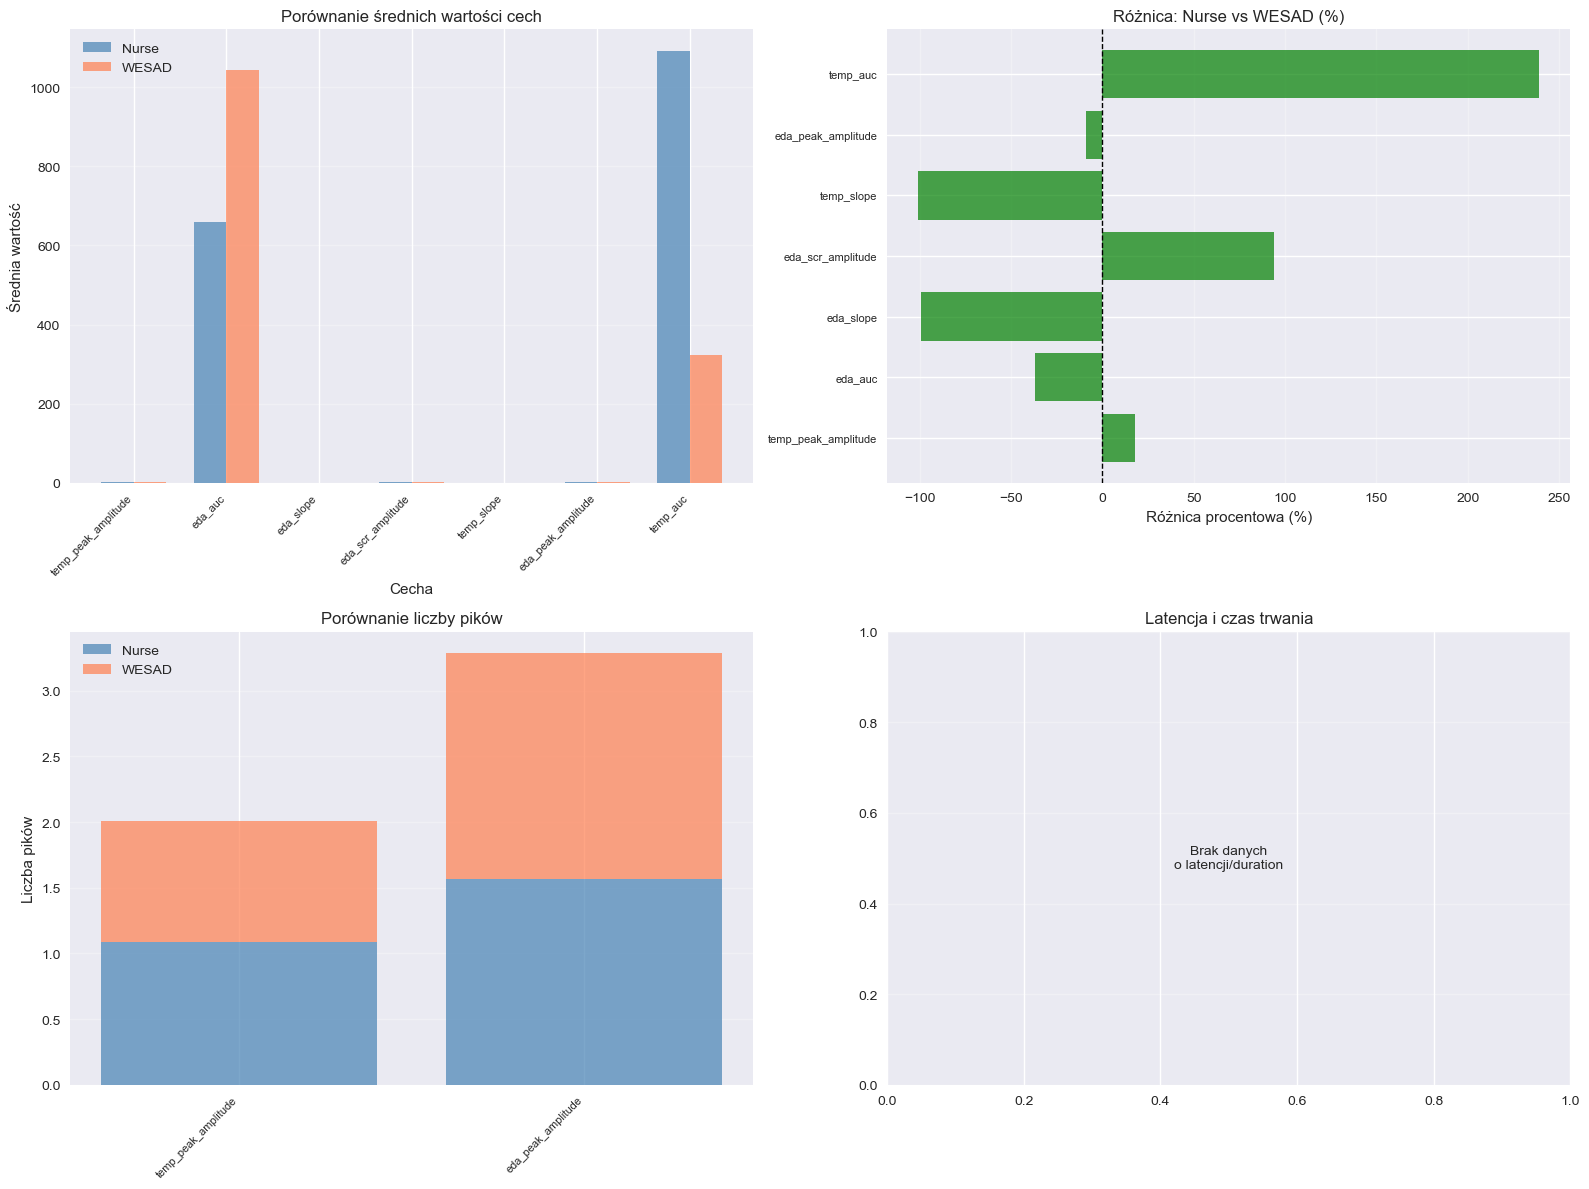


✅ Porównanie zakończone!


In [56]:
# 🔹 PORÓWNANIE CECH NURSE vs WESAD
print("=" * 80)
print("PORÓWNANIE CECH FIZJOLOGICZNYCH: NURSE vs WESAD")
print("=" * 80)

# Wczytaj cechy WESAD (jeśli dostępne) - sprawdź różne lokalizacje
wesad_files = [
    results_dir / 'wesad_features_full.csv',
    Path("../../notebooks/wesad_features_full.csv"),
    Path("../notebooks/wesad_features_full.csv"),
    notebook_dir.parent.parent / 'notebooks' / 'wesad_features_full.csv',
    Path("/Users/turfian/Downloads/archive (4)/WESAD/wesad-prep/notebooks/wesad_features_full.csv")
]

df_wesad_features = None
wesad_features_file = None

for wesad_file in wesad_files:
    if wesad_file.exists():
        try:
            df_wesad_features = pd.read_csv(wesad_file)
            wesad_features_file = wesad_file
            print(f"\n📁 Wczytano cechy WESAD z: {wesad_file}")
            print(f"   Rozmiar: {df_wesad_features.shape}")
            print(f"   Kolumny: {list(df_wesad_features.columns[:10])}...")
            break
        except Exception as e:
            print(f"   ⚠️ Błąd wczytywania {wesad_file}: {e}")
            continue

if df_wesad_features is None:
    print(f"\n   ⚠️ Nie znaleziono pliku wesad_features_full.csv w żadnej z lokalizacji:")
    for f in wesad_files:
        print(f"      - {f}")

# Sprawdź czy mamy cechy Nurse
if 'df_physiological' not in globals():
    if (results_dir / 'nurse_physiological_features.csv').exists():
        df_physiological = pd.read_csv(results_dir / 'nurse_physiological_features.csv')
        globals()['df_physiological'] = df_physiological
    else:
        df_physiological = None

if df_physiological is not None and df_wesad_features is not None:
    print(f"\n✅ Porównywanie cech...")
    
    # Znajdź wspólne cechy
    nurse_feature_cols = [col for col in df_physiological.columns if col not in ['id', 'person_id', 'nurse_id', 'subject']]
    wesad_feature_cols = [col for col in df_wesad_features.columns if col not in ['subject', 'label', 'id']]
    
    # Normalizuj nazwy (usuń prefiksy, lowercase)
    def normalize_feat_name(name):
        name = name.lower().replace('_mean', '').replace('_std', '').replace('nurse_', '').replace('wesad_', '')
        return name
    
    nurse_feat_map = {normalize_feat_name(col): col for col in nurse_feature_cols}
    wesad_feat_map = {normalize_feat_name(col): col for col in wesad_feature_cols}
    
    common_features = set(nurse_feat_map.keys()) & set(wesad_feat_map.keys())
    
    print(f"\n✅ Znaleziono {len(common_features)} wspólnych cech:")
    for feat_norm in list(common_features)[:10]:
        print(f"   - {feat_norm}: Nurse='{nurse_feat_map[feat_norm]}' <-> WESAD='{wesad_feat_map[feat_norm]}'")
    
    # Porównaj wartości
    comparison_results = []
    
    for feat_norm in list(common_features)[:15]:  # Max 15 cech
        nurse_col = nurse_feat_map[feat_norm]
        wesad_col = wesad_feat_map[feat_norm]
        
        nurse_vals = df_physiological[nurse_col].dropna()
        wesad_vals = df_wesad_features[wesad_col].dropna()
        
        if len(nurse_vals) > 0 and len(wesad_vals) > 0:
            comparison_results.append({
                'Feature': feat_norm,
                'Nurse_mean': nurse_vals.mean(),
                'Nurse_std': nurse_vals.std(),
                'WESAD_mean': wesad_vals.mean(),
                'WESAD_std': wesad_vals.std(),
                'Difference': nurse_vals.mean() - wesad_vals.mean(),
                'Difference_pct': ((nurse_vals.mean() - wesad_vals.mean()) / wesad_vals.mean() * 100) if wesad_vals.mean() != 0 else 0
            })
    
    comparison_df = pd.DataFrame(comparison_results)
    
    if len(comparison_df) > 0:
        print(f"\n📊 Porównanie wartości:")
        print(comparison_df.to_string(index=False))
        
        # Zapisz
        comparison_df.to_csv(results_dir / 'nurse_wesad_physiological_comparison.csv', index=False)
        print(f"\n✅ Zapisano: nurse_wesad_physiological_comparison.csv")
        
        # Wizualizacja
        print(f"\n📊 Wizualizacja...")
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # Wykres 1: Porównanie średnich wartości
        ax1 = axes[0, 0]
        top_features = comparison_df.head(10)
        x = np.arange(len(top_features))
        width = 0.35
        
        ax1.bar(x - width/2, top_features['Nurse_mean'], width, label='Nurse', alpha=0.7, color='steelblue')
        ax1.bar(x + width/2, top_features['WESAD_mean'], width, label='WESAD', alpha=0.7, color='coral')
        
        ax1.set_xlabel('Cecha')
        ax1.set_ylabel('Średnia wartość')
        ax1.set_title('Porównanie średnich wartości cech')
        ax1.set_xticks(x)
        ax1.set_xticklabels(top_features['Feature'], rotation=45, ha='right', fontsize=8)
        ax1.legend()
        ax1.grid(True, alpha=0.3, axis='y')
        
        # Wykres 2: Różnice procentowe
        ax2 = axes[0, 1]
        ax2.barh(range(len(top_features)), top_features['Difference_pct'], color='green', alpha=0.7)
        ax2.set_yticks(range(len(top_features)))
        ax2.set_yticklabels(top_features['Feature'], fontsize=8)
        ax2.set_xlabel('Różnica procentowa (%)')
        ax2.set_title('Różnica: Nurse vs WESAD (%)')
        ax2.axvline(x=0, color='black', linestyle='--', linewidth=1)
        ax2.grid(True, alpha=0.3, axis='x')
        
        # Wykres 3: Piki (jeśli dostępne)
        ax3 = axes[1, 0]
        peak_features = [f for f in comparison_df['Feature'] if 'peak' in f.lower() or 'n_peaks' in f.lower()]
        if len(peak_features) > 0:
            peak_data = comparison_df[comparison_df['Feature'].isin(peak_features)].head(5)
            ax3.bar(range(len(peak_data)), peak_data['Nurse_mean'], alpha=0.7, label='Nurse', color='steelblue')
            ax3.bar(range(len(peak_data)), peak_data['WESAD_mean'], alpha=0.7, label='WESAD', color='coral', bottom=peak_data['Nurse_mean'])
            ax3.set_xticks(range(len(peak_data)))
            ax3.set_xticklabels(peak_data['Feature'], rotation=45, ha='right', fontsize=8)
            ax3.set_ylabel('Liczba pików')
            ax3.set_title('Porównanie liczby pików')
            ax3.legend()
        else:
            ax3.text(0.5, 0.5, 'Brak danych\no pikach', ha='center', va='center', transform=ax3.transAxes)
            ax3.set_title('Liczba pików')
        ax3.grid(True, alpha=0.3, axis='y')
        
        # Wykres 4: Latencja i czas trwania (jeśli dostępne)
        ax4 = axes[1, 1]
        time_features = [f for f in comparison_df['Feature'] if 'latency' in f.lower() or 'duration' in f.lower()]
        if len(time_features) > 0:
            time_data = comparison_df[comparison_df['Feature'].isin(time_features)].head(5)
            x = np.arange(len(time_data))
            width = 0.35
            ax4.bar(x - width/2, time_data['Nurse_mean'], width, label='Nurse', alpha=0.7, color='steelblue')
            ax4.bar(x + width/2, time_data['WESAD_mean'], width, label='WESAD', alpha=0.7, color='coral')
            ax4.set_xticks(x)
            ax4.set_xticklabels(time_data['Feature'], rotation=45, ha='right', fontsize=8)
            ax4.set_ylabel('Czas (s)')
            ax4.set_title('Latencja i czas trwania reakcji')
            ax4.legend()
        else:
            ax4.text(0.5, 0.5, 'Brak danych\no latencji/duration', ha='center', va='center', transform=ax4.transAxes)
            ax4.set_title('Latencja i czas trwania')
        ax4.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.savefig(results_dir / 'nurse_wesad_physiological_comparison.png', dpi=300, bbox_inches='tight')
        print(f"   ✅ Zapisano: nurse_wesad_physiological_comparison.png")
        plt.show()
        
        globals()['physiological_comparison'] = comparison_df
        print(f"\n✅ Porównanie zakończone!")
    else:
        print(f"\n   ⚠️ Brak wspólnych cech do porównania")
        
elif df_physiological is None:
    print(f"\n❌ Brak cech fizjologicznych Nurse - uruchom najpierw KROK 2.5!")
elif df_wesad_features is None:
    print(f"\n❌ Brak cech WESAD - sprawdź czy plik istnieje")
else:
    print(f"\n❌ Brak danych do porównania")


## KROK 2.7: Streamlit App - Porównanie cech fizjologicznych

**Cel:** Stwórz interaktywną aplikację Streamlit do wizualizacji porównania Nurse vs WESAD.


In [57]:
# 🔹 GENEROWANIE STREAMLIT APP - PORÓWNANIE CECH FIZJOLOGICZNYCH
print("=" * 80)
print("GENEROWANIE STREAMLIT APP - PORÓWNANIE NURSE vs WESAD")
print("=" * 80)

# Sprawdź czy mamy dane porównawcze
comparison_file = results_dir / 'nurse_wesad_physiological_comparison.csv'
physiological_file = results_dir / 'nurse_physiological_features.csv'

if not comparison_file.exists() and 'physiological_comparison' not in globals():
    print(f"\n⚠️ Brak pliku porównawczego: {comparison_file}")
    print(f"   Uruchom najpierw KROK 2.6 (Porównanie cech)!")
else:
    streamlit_code = '''
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

st.set_page_config(page_title="Nurse vs WESAD - Porównanie cech fizjologicznych", layout="wide", page_icon="🏥")

st.title("🏥 Porównanie cech fizjologicznych: Nurse vs WESAD")
st.markdown("---")

# Wczytaj dane
@st.cache_data
def load_comparison_data():
    """Wczytuje dane porównawcze"""
    app_dir = Path(__file__).parent if '__file__' in globals() else Path.cwd()
    results_dir = app_dir.parent / 'results'
    if not results_dir.exists():
        results_dir = app_dir / 'results'
    if not results_dir.exists():
        results_dir = Path("../results")
    
    comparison_file = results_dir / 'nurse_wesad_physiological_comparison.csv'
    physiological_file = results_dir / 'nurse_physiological_features.csv'
    
    comparison_df = None
    physiological_df = None
    
    if comparison_file.exists():
        try:
            comparison_df = pd.read_csv(comparison_file)
        except Exception as e:
            st.error(f"Błąd wczytywania porównania: {e}")
    
    if physiological_file.exists():
        try:
            physiological_df = pd.read_csv(physiological_file)
        except Exception as e:
            st.warning(f"Błąd wczytywania cech: {e}")
    
    return comparison_df, physiological_df, results_dir

comparison_df, physiological_df, results_dir = load_comparison_data()

if comparison_df is None or len(comparison_df) == 0:
    st.error("❌ Brak danych porównawczych!")
    st.info("💡 Uruchom najpierw KROK 2.6 w notebooku, aby wygenerować dane porównawcze.")
else:
    st.success(f"✅ Wczytano {len(comparison_df)} cech do porównania")
    
    # Sidebar
    st.sidebar.header("⚙️ Filtry i opcje")
    
    # Filtry
    feature_types = st.sidebar.multiselect(
        "Typy cech:",
        options=['Wszystkie', 'Piki', 'Latencja', 'Czas trwania', 'AUC', 'Slope', 'RMSSD', 'Statystyki'],
        default=['Wszystkie']
    )
    
    min_diff_pct = st.sidebar.slider(
        "Minimalna różnica procentowa:",
        min_value=-100.0,
        max_value=100.0,
        value=-100.0,
        step=5.0
    )
    
    # Filtruj dane
    filtered_df = comparison_df.copy()
    
    if 'Wszystkie' not in feature_types:
        mask = False
        for ft in feature_types:
            if ft == 'Piki':
                mask |= filtered_df['Feature'].str.contains('peak', case=False, na=False)
            elif ft == 'Latencja':
                mask |= filtered_df['Feature'].str.contains('latency', case=False, na=False)
            elif ft == 'Czas trwania':
                mask |= filtered_df['Feature'].str.contains('duration', case=False, na=False)
            elif ft == 'AUC':
                mask |= filtered_df['Feature'].str.contains('auc', case=False, na=False)
            elif ft == 'Slope':
                mask |= filtered_df['Feature'].str.contains('slope', case=False, na=False)
            elif ft == 'RMSSD':
                mask |= filtered_df['Feature'].str.contains('rmssd', case=False, na=False)
            elif ft == 'Statystyki':
                mask |= (filtered_df['Feature'].str.contains('mean', case=False, na=False) |
                        filtered_df['Feature'].str.contains('std', case=False, na=False) |
                        filtered_df['Feature'].str.contains('min', case=False, na=False) |
                        filtered_df['Feature'].str.contains('max', case=False, na=False))
        filtered_df = filtered_df[mask]
    
    filtered_df = filtered_df[filtered_df['Difference_pct'].abs() >= abs(min_diff_pct)]
    
    st.sidebar.info(f"📊 Wyświetlanych cech: {len(filtered_df)}")
    
    # Główne metryki
    st.markdown("### 📊 Podsumowanie porównania")
    
    col1, col2, col3, col4 = st.columns(4)
    
    with col1:
        avg_diff = filtered_df['Difference_pct'].mean()
        st.metric("Średnia różnica", f"{avg_diff:.1f}%")
    
    with col2:
        nurse_higher = len(filtered_df[filtered_df['Difference_pct'] > 0])
        st.metric("Cechy wyższe w Nurse", nurse_higher)
    
    with col3:
        wesad_higher = len(filtered_df[filtered_df['Difference_pct'] < 0])
        st.metric("Cechy wyższe w WESAD", wesad_higher)
    
    with col4:
        max_diff_feat = filtered_df.loc[filtered_df['Difference_pct'].abs().idxmax(), 'Feature']
        st.metric("Największa różnica", max_diff_feat[:20] + "...")
    
    # Wykresy
    st.markdown("---")
    st.subheader("📈 Wizualizacje")
    
    # Wykres 1: Porównanie średnich wartości (interaktywny)
    st.markdown("#### 1. Porównanie średnich wartości cech")
    
    top_n = st.slider("Liczba cech do wyświetlenia:", 5, min(30, len(filtered_df)), 15)
    top_features = filtered_df.nlargest(top_n, 'Difference_pct', keep='all')
    
    fig1 = go.Figure()
    
    fig1.add_trace(go.Bar(
        x=top_features['Feature'],
        y=top_features['Nurse_mean'],
        name='Nurse',
        marker_color='steelblue',
        error_y=dict(type='data', array=top_features['Nurse_std'])
    ))
    
    fig1.add_trace(go.Bar(
        x=top_features['Feature'],
        y=top_features['WESAD_mean'],
        name='WESAD',
        marker_color='coral',
        error_y=dict(type='data', array=top_features['WESAD_std'])
    ))
    
    fig1.update_layout(
        title='Porównanie średnich wartości cech (z odchyleniami standardowymi)',
        xaxis_title='Cecha',
        yaxis_title='Średnia wartość',
        barmode='group',
        height=500,
        xaxis=dict(tickangle=-45)
    )
    
    st.plotly_chart(fig1, use_container_width=True)
    
    # Wykres 2: Różnice procentowe
    st.markdown("#### 2. Różnice procentowe: Nurse vs WESAD")
    
    fig2 = go.Figure()
    
    colors = ['green' if x > 0 else 'red' for x in top_features['Difference_pct']]
    
    fig2.add_trace(go.Bar(
        y=top_features['Feature'],
        x=top_features['Difference_pct'],
        orientation='h',
        marker_color=colors,
        text=[f"{x:.1f}%" for x in top_features['Difference_pct']],
        textposition='auto'
    ))
    
    fig2.add_vline(x=0, line_dash="dash", line_color="black", annotation_text="Brak różnicy")
    
    fig2.update_layout(
        title='Różnica procentowa: Nurse vs WESAD',
        xaxis_title='Różnica procentowa (%)',
        yaxis_title='Cecha',
        height=500
    )
    
    st.plotly_chart(fig2, use_container_width=True)
    
    # Wykres 3: Piki (jeśli dostępne)
    peak_features = filtered_df[filtered_df['Feature'].str.contains('peak', case=False, na=False)]
    if len(peak_features) > 0:
        st.markdown("#### 3. Porównanie pików")
        
        fig3 = go.Figure()
        
        fig3.add_trace(go.Bar(
            x=peak_features['Feature'],
            y=peak_features['Nurse_mean'],
            name='Nurse',
            marker_color='steelblue'
        ))
        
        fig3.add_trace(go.Bar(
            x=peak_features['Feature'],
            y=peak_features['WESAD_mean'],
            name='WESAD',
            marker_color='coral'
        ))
        
        fig3.update_layout(
            title='Liczba pików w sygnałach',
            xaxis_title='Cecha',
            yaxis_title='Liczba pików',
            barmode='group',
            height=400,
            xaxis=dict(tickangle=-45)
        )
        
        st.plotly_chart(fig3, use_container_width=True)
    
    # Wykres 4: Latencja i czas trwania (jeśli dostępne)
    time_features = filtered_df[filtered_df['Feature'].str.contains('latency|duration', case=False, na=False)]
    if len(time_features) > 0:
        st.markdown("#### 4. Latencja i czas trwania reakcji")
        
        fig4 = go.Figure()
        
        fig4.add_trace(go.Bar(
            x=time_features['Feature'],
            y=time_features['Nurse_mean'],
            name='Nurse',
            marker_color='steelblue',
            error_y=dict(type='data', array=time_features['Nurse_std'])
        ))
        
        fig4.add_trace(go.Bar(
            x=time_features['Feature'],
            y=time_features['WESAD_mean'],
            name='WESAD',
            marker_color='coral',
            error_y=dict(type='data', array=time_features['WESAD_std'])
        ))
        
        fig4.update_layout(
            title='Czas latencji i trwania reakcji (w sekundach)',
            xaxis_title='Cecha',
            yaxis_title='Czas (s)',
            barmode='group',
            height=400,
            xaxis=dict(tickangle=-45)
        )
        
        st.plotly_chart(fig4, use_container_width=True)
    
    # Tabela szczegółowa
    st.markdown("---")
    st.subheader("📋 Tabela szczegółowa")
    
    # Sortowanie
    sort_by = st.selectbox(
        "Sortuj według:",
        options=['Feature', 'Difference_pct', 'Nurse_mean', 'WESAD_mean'],
        index=1
    )
    
    sorted_df = filtered_df.sort_values(sort_by, ascending=False)
    
    # Formatowanie
    display_df = sorted_df.copy()
    display_df['Nurse_mean'] = display_df['Nurse_mean'].round(3)
    display_df['Nurse_std'] = display_df['Nurse_std'].round(3)
    display_df['WESAD_mean'] = display_df['WESAD_mean'].round(3)
    display_df['WESAD_std'] = display_df['WESAD_std'].round(3)
    display_df['Difference'] = display_df['Difference'].round(3)
    display_df['Difference_pct'] = display_df['Difference_pct'].round(2)
    
    st.dataframe(
        display_df,
        use_container_width=True,
        height=400
    )
    
    # Pobierz CSV
    csv = display_df.to_csv(index=False)
    st.download_button(
        label="📥 Pobierz dane jako CSV",
        data=csv,
        file_name="nurse_wesad_comparison.csv",
        mime="text/csv"
    )
    
    # Statystyki per typ cechy
    st.markdown("---")
    st.subheader("📊 Statystyki per typ cechy")
    
    # Kategoryzuj cechy
    def categorize_feature(feat_name):
        feat_lower = feat_name.lower()
        if 'peak' in feat_lower:
            return 'Piki'
        elif 'latency' in feat_lower:
            return 'Latencja'
        elif 'duration' in feat_lower:
            return 'Czas trwania'
        elif 'auc' in feat_lower:
            return 'AUC'
        elif 'slope' in feat_lower:
            return 'Slope'
        elif 'rmssd' in feat_lower:
            return 'RMSSD'
        elif 'mean' in feat_lower or 'std' in feat_lower or 'min' in feat_lower or 'max' in feat_lower:
            return 'Statystyki'
        else:
            return 'Inne'
    
    filtered_df['Category'] = filtered_df['Feature'].apply(categorize_feature)
    
    category_stats = filtered_df.groupby('Category').agg({
        'Difference_pct': ['mean', 'std', 'count'],
        'Nurse_mean': 'mean',
        'WESAD_mean': 'mean'
    }).round(2)
    
    category_stats.columns = ['Średnia różnica %', 'Std różnicy %', 'Liczba cech', 'Śr. Nurse', 'Śr. WESAD']
    
    st.dataframe(category_stats, use_container_width=True)
    
    # Wykres kategorii
    fig_cat = go.Figure()
    
    fig_cat.add_trace(go.Bar(
        x=category_stats.index,
        y=category_stats['Średnia różnica %'],
        marker_color='lightblue',
        text=category_stats['Średnia różnica %'],
        textposition='auto'
    ))
    
    fig_cat.add_hline(y=0, line_dash="dash", line_color="black")
    
    fig_cat.update_layout(
        title='Średnia różnica procentowa per kategoria cech',
        xaxis_title='Kategoria',
        yaxis_title='Średnia różnica (%)',
        height=400
    )
    
    st.plotly_chart(fig_cat, use_container_width=True)

# Footer
st.markdown("---")
st.markdown("**💡 Wskazówka:** Uruchom KROK 2.6 w notebooku, aby zaktualizować dane porównawcze.")
'''

    # Zapisz Streamlit app
    streamlit_file = results_dir / 'nurse_wesad_comparison_streamlit.py'
    with open(streamlit_file, 'w', encoding='utf-8') as f:
        f.write(streamlit_code)
    
    print(f"\n✅ Zapisano Streamlit app: {streamlit_file}")
    print(f"\n" + "=" * 80)
    print("📋 INSTRUKCJE URUCHOMIENIA STREAMLIT (2 LINIE DO SKOPIOWANIA):")
    print("=" * 80)
    print(f"\ncd \"{results_dir}\"")
    print(f"streamlit run nurse_wesad_comparison_streamlit.py")
    print(f"\n" + "=" * 80)
    
    print(f"\n💡 Funkcje Streamlit app:")
    print(f"   ✅ Interaktywne wykresy (Plotly)")
    print(f"   ✅ Filtrowanie po typach cech")
    print(f"   ✅ Porównanie średnich wartości z odchyleniami")
    print(f"   ✅ Różnice procentowe")
    print(f"   ✅ Wykresy pików, latencji i czasu trwania")
    print(f"   ✅ Statystyki per kategoria cech")
    print(f"   ✅ Tabela szczegółowa z możliwością sortowania")
    print(f"   ✅ Pobieranie danych jako CSV")


GENEROWANIE STREAMLIT APP - PORÓWNANIE NURSE vs WESAD

✅ Zapisano Streamlit app: /Users/turfian/Downloads/archive (4)/WESAD/wesad-prep/nurse-stress-analysis/results/nurse_wesad_comparison_streamlit.py

📋 INSTRUKCJE URUCHOMIENIA STREAMLIT (2 LINIE DO SKOPIOWANIA):

cd "/Users/turfian/Downloads/archive (4)/WESAD/wesad-prep/nurse-stress-analysis/results"
streamlit run nurse_wesad_comparison_streamlit.py


💡 Funkcje Streamlit app:
   ✅ Interaktywne wykresy (Plotly)
   ✅ Filtrowanie po typach cech
   ✅ Porównanie średnich wartości z odchyleniami
   ✅ Różnice procentowe
   ✅ Wykresy pików, latencji i czasu trwania
   ✅ Statystyki per kategoria cech
   ✅ Tabela szczegółowa z możliwością sortowania
   ✅ Pobieranie danych jako CSV


## KROK 3: Przygotowanie danych i etykiet


In [58]:
# 🔹 PRZYGOTOWANIE DANYCH I ETYKIET
print("=" * 80)
print("PRZYGOTOWANIE DANYCH")
print("=" * 80)

if 'df_nurse' not in globals() or df_nurse is None:
    print("\n❌ Brak danych - uruchom najpierw KROK 2!")
else:
    # Znajdź kolumnę z ID osoby
    id_col = None
    for col in ['id', 'person_id', 'nurse_id', 'subject', 'person']:
        if col in df_nurse.columns:
            id_col = col
            break
    
    if id_col is None:
        print("   ⚠️ Brak kolumny ID - tworzę sztuczne ID")
        df_nurse['person_id'] = (df_nurse.index // 100).astype(str)
        id_col = 'person_id'
    
    print(f"\n✅ Kolumna ID: {id_col}")
    print(f"   Liczba unikalnych osób: {df_nurse[id_col].nunique()}")
    
    # Znajdź kolumnę z etykietami (stress)
    label_col = None
    for col in ['label', 'stress', 'stress_level', 'class', 'target']:
        if col in df_nurse.columns:
            label_col = col
            break
    
    if label_col is None:
        print("\n   ⚠️ Brak etykiet - tworzę na podstawie percentyli")
        # Znajdź pierwszą numeryczną kolumnę jako bazę
        numeric_cols = df_nurse.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) > 0:
            base_col = numeric_cols[0]
            median_val = df_nurse[base_col].median()
            df_nurse['label'] = (df_nurse[base_col] > median_val).astype(int)
            label_col = 'label'
            print(f"   Utworzono etykiety na podstawie {base_col} (mediana={median_val:.3f})")
    else:
        print(f"\n✅ Kolumna etykiet: {label_col}")
    
    if label_col:
        print(f"   Rozkład etykiet: {df_nurse[label_col].value_counts().to_dict()}")
    
    # Wybierz cechy (pomijając ID i etykiety)
    exclude_cols = [id_col, label_col, 'datetime', 'timestamp', 'date', 'time']
    feature_cols = [col for col in df_nurse.columns if col not in exclude_cols]
    
    # Tylko numeryczne cechy
    feature_cols = [col for col in feature_cols if df_nurse[col].dtype in ['int64', 'float64']]
    
    print(f"\n✅ Znaleziono {len(feature_cols)} cech numerycznych")
    
    # Przygotuj X i y
    X = df_nurse[feature_cols].copy()
    
    # Wypełnij braki medianą
    for col in feature_cols:
        if X[col].isna().any():
            median_val = X[col].median()
            if pd.isna(median_val):
                median_val = 0
            X[col].fillna(median_val, inplace=True)
    
    if label_col:
        y = df_nurse[label_col].copy()
        
        # Encode labels jeśli nie są numeryczne
        if y.dtype == 'object':
            le = LabelEncoder()
            y = le.fit_transform(y)
            print(f"   ✅ Etykiety zakodowane: {np.unique(y)}")
    else:
        y = None
        print("   ⚠️ Brak etykiet - pomijam trening modeli")
    
    # Zapisz do globals
    globals()['X'] = X
    globals()['y'] = y
    globals()['feature_cols'] = feature_cols
    globals()['id_col'] = id_col
    globals()['label_col'] = label_col
    
    print(f"\n✅ Dane przygotowane:")
    print(f"   X: {X.shape}")
    if y is not None:
        print(f"   y: {y.shape}, klasy: {np.unique(y)}")


PRZYGOTOWANIE DANYCH

✅ Kolumna ID: id
   Liczba unikalnych osób: 3

✅ Kolumna etykiet: label
   Rozkład etykiet: {1.0: 1605, 0.0: 666}

✅ Znaleziono 133 cech numerycznych

✅ Dane przygotowane:
   X: (2271, 133)
   y: (2271,), klasy: [0. 1.]


## KROK 4: Trening modeli ML


In [59]:
# 🔹 TRENING MODELI ML
print("=" * 80)
print("TRENING MODELI ML")
print("=" * 80)

if 'X' not in globals() or 'y' not in globals() or y is None:
    print("\n❌ Brak danych - uruchom najpierw KROK 3!")
else:
    # Podziel dane
    class_counts = pd.Series(y).value_counts()
    
    if len(class_counts) < 2 or class_counts.min() < 2:
        print(f"\n❌ Za mało próbek w klasach: {class_counts.to_dict()}")
        print("   Nie można trenować modeli")
    else:
        stratify_param = y if len(class_counts) == 2 and class_counts.min() >= 2 else None
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=stratify_param
        )
        
        print(f"\n✅ Podział danych:")
        print(f"   Train: {X_train.shape}")
        print(f"   Test: {X_test.shape}")
        
        # Skaluj
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        print(f"\n✅ Dane przeskalowane")
        
        # Modele do przetestowania
        models = {
            'LogisticRegression': LogisticRegression(random_state=RANDOM_SEED, max_iter=1000),
            'RandomForest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED, max_depth=10),
            'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_SEED, max_depth=5),
            'ExtraTrees': ExtraTreesClassifier(n_estimators=100, random_state=RANDOM_SEED, max_depth=10),
        }
        
        results = []
        trained_models = {}
        
        print(f"\n🌲 Trenuję {len(models)} modeli...")
        
        for name, model in models.items():
            try:
                print(f"\n   {name}...")
                model.fit(X_train_scaled, y_train)
                
                # Predykcje
                y_pred = model.predict(X_test_scaled)
                
                # Metryki
                acc = accuracy_score(y_test, y_pred)
                f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
                prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
                rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
                
                # ROC-AUC (tylko dla binarnych)
                if len(np.unique(y_test)) == 2:
                    try:
                        y_proba = model.predict_proba(X_test_scaled)[:, 1]
                        roc_auc = roc_auc_score(y_test, y_proba)
                    except:
                        roc_auc = 0.0
                else:
                    roc_auc = 0.0
                
                results.append({
                    'Model': name,
                    'Accuracy': acc,
                    'F1-Score': f1,
                    'Precision': prec,
                    'Recall': rec,
                    'ROC-AUC': roc_auc
                })
                
                trained_models[name] = model
                
                print(f"      Accuracy: {acc:.3f}, F1: {f1:.3f}, ROC-AUC: {roc_auc:.3f}")
                
            except Exception as e:
                print(f"      ❌ Błąd: {e}")
                continue
        
        # Wyniki
        results_df = pd.DataFrame(results)
        results_df = results_df.sort_values('Accuracy', ascending=False)
        
        print(f"\n" + "=" * 80)
        print("WYNIKI MODELI:")
        print("=" * 80)
        print(results_df.to_string(index=False))
        
        # Zapisz
        results_df.to_csv(results_dir / 'nurse_ml_results.csv', index=False)
        print(f"\n✅ Zapisano: nurse_ml_results.csv")
        
        # Najlepszy model
        best_model_name = results_df.iloc[0]['Model']
        best_model = trained_models[best_model_name]
        
        print(f"\n🏆 Najlepszy model: {best_model_name}")
        print(f"   Accuracy: {results_df.iloc[0]['Accuracy']:.3f}")
        
        # Zapisz do globals
        globals()['results_df'] = results_df
        globals()['trained_models'] = trained_models
        globals()['best_model'] = best_model
        globals()['best_model_name'] = best_model_name
        globals()['scaler'] = scaler
        globals()['X_test_scaled'] = X_test_scaled
        globals()['y_test'] = y_test


TRENING MODELI ML

✅ Podział danych:
   Train: (1816, 133)
   Test: (455, 133)

✅ Dane przeskalowane

🌲 Trenuję 4 modeli...

   LogisticRegression...
      Accuracy: 0.895, F1: 0.892, ROC-AUC: 0.929

   RandomForest...
      Accuracy: 0.943, F1: 0.942, ROC-AUC: 0.980

   GradientBoosting...
      Accuracy: 0.954, F1: 0.953, ROC-AUC: 0.992

   ExtraTrees...
      Accuracy: 0.938, F1: 0.937, ROC-AUC: 0.988

WYNIKI MODELI:
             Model  Accuracy  F1-Score  Precision   Recall  ROC-AUC
  GradientBoosting  0.953846  0.953356   0.953785 0.953846 0.992108
      RandomForest  0.942857  0.941721   0.943539 0.942857 0.979650
        ExtraTrees  0.938462  0.936887   0.939990 0.938462 0.987508
LogisticRegression  0.894505  0.892408   0.893026 0.894505 0.929272

✅ Zapisano: nurse_ml_results.csv

🏆 Najlepszy model: GradientBoosting
   Accuracy: 0.954


## KROK 5: Wizualizacja wyników


WIZUALIZACJA WYNIKÓW

✅ Zapisano: nurse_ml_analysis.png


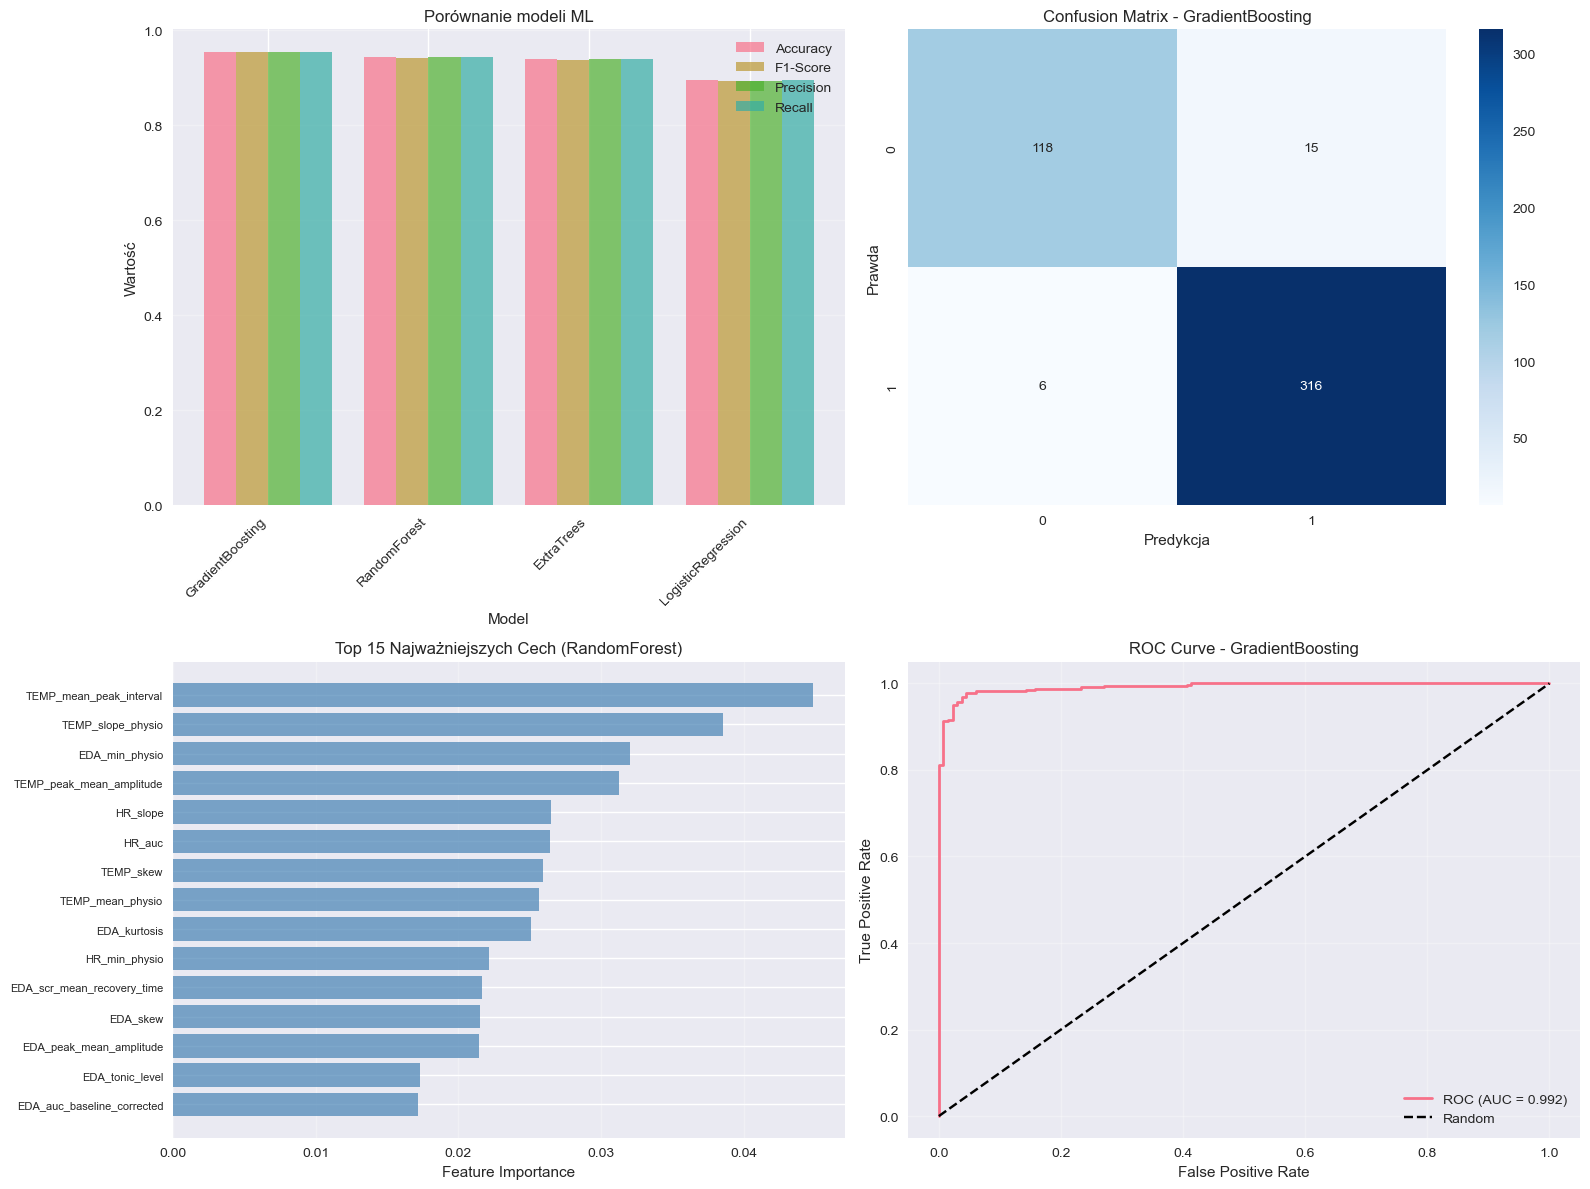

In [60]:
# 🔹 WIZUALIZACJA WYNIKÓW
print("=" * 80)
print("WIZUALIZACJA WYNIKÓW")
print("=" * 80)

if 'results_df' not in globals():
    print("\n❌ Brak wyników - uruchom najpierw KROK 4!")
else:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Wykres 1: Porównanie modeli
    ax1 = axes[0, 0]
    metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
    x = np.arange(len(results_df))
    width = 0.2
    
    for i, metric in enumerate(metrics):
        ax1.bar(x + i*width, results_df[metric], width, label=metric, alpha=0.7)
    
    ax1.set_xlabel('Model')
    ax1.set_ylabel('Wartość')
    ax1.set_title('Porównanie modeli ML')
    ax1.set_xticks(x + width * 1.5)
    ax1.set_xticklabels(results_df['Model'], rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Wykres 2: Confusion Matrix (najlepszy model)
    ax2 = axes[0, 1]
    if 'best_model' in globals() and 'y_test' in globals():
        y_pred_best = best_model.predict(X_test_scaled)
        cm = confusion_matrix(y_test, y_pred_best)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2)
        ax2.set_title(f'Confusion Matrix - {best_model_name}')
        ax2.set_ylabel('Prawda')
        ax2.set_xlabel('Predykcja')
    
    # Wykres 3: Feature Importance (jeśli RandomForest)
    ax3 = axes[1, 0]
    if 'RandomForest' in trained_models:
        rf = trained_models['RandomForest']
        importances = rf.feature_importances_
        indices = np.argsort(importances)[::-1][:15]  # Top 15
        
        ax3.barh(range(len(indices)), importances[indices], color='steelblue', alpha=0.7)
        ax3.set_yticks(range(len(indices)))
        ax3.set_yticklabels([feature_cols[i] for i in indices], fontsize=8)
        ax3.set_xlabel('Feature Importance')
        ax3.set_title('Top 15 Najważniejszych Cech (RandomForest)')
        ax3.invert_yaxis()
        ax3.grid(True, alpha=0.3, axis='x')
    
    # Wykres 4: ROC Curve (jeśli binarna klasyfikacja)
    ax4 = axes[1, 1]
    if len(np.unique(y_test)) == 2 and 'best_model' in globals():
        try:
            y_proba = best_model.predict_proba(X_test_scaled)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            roc_auc = roc_auc_score(y_test, y_proba)
            
            ax4.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.3f})', linewidth=2)
            ax4.plot([0, 1], [0, 1], 'k--', label='Random')
            ax4.set_xlabel('False Positive Rate')
            ax4.set_ylabel('True Positive Rate')
            ax4.set_title(f'ROC Curve - {best_model_name}')
            ax4.legend()
            ax4.grid(True, alpha=0.3)
        except:
            ax4.text(0.5, 0.5, 'Brak danych\ndla ROC curve', ha='center', va='center', transform=ax4.transAxes)
    
    plt.tight_layout()
    plt.savefig(results_dir / 'nurse_ml_analysis.png', dpi=300, bbox_inches='tight')
    print(f"\n✅ Zapisano: nurse_ml_analysis.png")
    plt.show()


## KROK 6: Streamlit App


In [61]:
# 🔹 GENEROWANIE STREAMLIT APP
print("=" * 80)
print("GENEROWANIE STREAMLIT APP")
print("=" * 80)

if 'best_model' not in globals():
    print("\n❌ Brak modelu - uruchom najpierw KROK 4!")
else:
    streamlit_code = '''
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objects as go

st.set_page_config(page_title="Nurse Stress Analysis", layout="wide")

st.title("🏥 Nurse Stress - Analiza ML")
st.markdown("---")

# Wczytaj dane
@st.cache_data
def load_data():
    app_dir = Path(__file__).parent if '__file__' in globals() else Path.cwd()
    results_dir = app_dir.parent / 'results'
    if not results_dir.exists():
        results_dir = app_dir / 'results'
    if not results_dir.exists():
        results_dir = Path("../results")
    
    try:
        results_df = pd.read_csv(results_dir / 'nurse_ml_results.csv')
        return results_df, results_dir
    except FileNotFoundError:
        st.error("Brak pliku nurse_ml_results.csv - uruchom najpierw analizę w notebooku!")
        return None, None

results_df, results_dir = load_data()

if results_df is not None:
    # Sidebar
    st.sidebar.header("⚙️ Konfiguracja")
    
    # Wybór modelu
    selected_model = st.sidebar.selectbox("Wybierz model:", results_df['Model'].tolist())
    
    # Filtruj wyniki
    model_results = results_df[results_df['Model'] == selected_model].iloc[0]
    
    # Główne metryki
    col1, col2, col3, col4 = st.columns(4)
    
    with col1:
        st.metric("Accuracy", f"{model_results['Accuracy']:.3f}")
    
    with col2:
        st.metric("F1-Score", f"{model_results['F1-Score']:.3f}")
    
    with col3:
        st.metric("Precision", f"{model_results['Precision']:.3f}")
    
    with col4:
        st.metric("Recall", f"{model_results['Recall']:.3f}")
    
    # Wykresy
    st.markdown("---")
    st.subheader("📊 Porównanie modeli")
    
    col1, col2 = st.columns(2)
    
    with col1:
        fig, ax = plt.subplots(figsize=(10, 6))
        metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
        x = np.arange(len(results_df))
        width = 0.2
        
        for i, metric in enumerate(metrics):
            ax.bar(x + i*width, results_df[metric], width, label=metric, alpha=0.7)
        
        ax.set_xlabel('Model')
        ax.set_ylabel('Wartość')
        ax.set_title('Porównanie modeli ML')
        ax.set_xticks(x + width * 1.5)
        ax.set_xticklabels(results_df['Model'], rotation=45, ha='right')
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')
        st.pyplot(fig)
    
    with col2:
        st.dataframe(results_df.style.highlight_max(axis=0))
    
    # Statystyki
    st.markdown("---")
    st.subheader("📈 Statystyki")
    st.write(f"**Najlepszy model:** {results_df.iloc[0]['Model']}")
    st.write(f"**Accuracy:** {results_df.iloc[0]['Accuracy']:.3f}")
    st.write(f"**F1-Score:** {results_df.iloc[0]['F1-Score']:.3f}")

else:
    st.warning("Brak danych - uruchom najpierw analizę w notebooku!")
'''
    
    # Zapisz Streamlit app
    streamlit_file = results_dir / 'nurse_stress_streamlit_app.py'
    with open(streamlit_file, 'w', encoding='utf-8') as f:
        f.write(streamlit_code)
    
    print(f"\n✅ Zapisano Streamlit app: {streamlit_file}")
    print(f"\n" + "=" * 80)
    print("📋 INSTRUKCJE URUCHOMIENIA STREAMLIT (2 LINIE DO SKOPIOWANIA):")
    print("=" * 80)
    print(f"\ncd \"{results_dir}\"")
    print(f"streamlit run nurse_stress_streamlit_app.py")
    print(f"\n" + "=" * 80)


GENEROWANIE STREAMLIT APP

✅ Zapisano Streamlit app: /Users/turfian/Downloads/archive (4)/WESAD/wesad-prep/nurse-stress-analysis/results/nurse_stress_streamlit_app.py

📋 INSTRUKCJE URUCHOMIENIA STREAMLIT (2 LINIE DO SKOPIOWANIA):

cd "/Users/turfian/Downloads/archive (4)/WESAD/wesad-prep/nurse-stress-analysis/results"
streamlit run nurse_stress_streamlit_app.py



## KROK 7: Pipeline porównania Nurse → WESAD

**Cel:** Porównanie profili Nurse z centroidami WESAD (baseline, stress) używając najważniejszych cech.


In [62]:
# 🔹 PIPELINE PORÓWNANIA NURSE → WESAD
print("=" * 80)
print("PIPELINE PORÓWNANIA NURSE → WESAD")
print("=" * 80)

from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# KROK 1: Wybór cech z Nurse (feature importance)
print("\n" + "=" * 80)
print("KROK 1: WYBÓR CECH Z NURSE (Feature Importance)")
print("=" * 80)

# Sprawdź dostępność wszystkich potrzebnych zmiennych
required_vars = {
    'best_model': 'Najlepszy model (z KROK 4)',
    'X': 'Dane wejściowe (z KROK 3)',
    'feature_cols': 'Lista cech (z KROK 3)',
    'best_model_name': 'Nazwa najlepszego modelu (z KROK 4)'
}

missing_vars = []
for var_name, var_desc in required_vars.items():
    if var_name not in globals() or globals()[var_name] is None:
        missing_vars.append(f"{var_name} ({var_desc})")

if missing_vars:
    print("\n❌ Brakujące zmienne:")
    for var in missing_vars:
        print(f"   - {var}")
    print("\n💡 Rozwiązanie:")
    print("   1. Uruchom KROK 2: Wczytaj dane Nurse")
    print("   2. Uruchom KROK 3: Przygotowanie danych i etykiet")
    print("   3. Uruchom KROK 4: Trening modeli ML")
    print("   4. Następnie uruchom KROK 7 ponownie")
else:
        # Sprawdź czy model ma feature_importances_
    if not hasattr(best_model, 'feature_importances_'):
        print("\n⚠️ Model nie ma feature_importances_")
        print(f"   Typ modelu: {type(best_model).__name__}")
        print("   Używam wszystkich cech zamiast feature importance...")
        
        # Użyj wszystkich cech lub pierwszych 5
        if 'feature_cols' in globals() and len(feature_cols) > 0:
            selected_features = feature_cols[:5]
            print(f"\n✅ Wybrano pierwsze 5 cech (bez feature importance):")
            for i, feat in enumerate(selected_features, 1):
                print(f"   {i}. {feat}")
        else:
            print("\n❌ Brak listy cech - nie można kontynuować")
            selected_features = []
    else:
        # Wyciągnij feature importance
        importances = best_model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'Feature': feature_cols,
            'Importance': importances
        }).sort_values('Importance', ascending=False)
        
        print(f"\n✅ Feature importance wyciągnięte z {best_model_name}")
        print(f"\n   Top 10 najważniejszych cech:")
        print(feature_importance_df.head(10).to_string(index=False))
        
        # Wybierz top N cech
        TOP_N_FEATURES = 5
        selected_features = feature_importance_df.head(TOP_N_FEATURES)['Feature'].tolist()
        
        print(f"\n✅ Wybrano top {TOP_N_FEATURES} cech:")
        for i, feat in enumerate(selected_features, 1):
            print(f"   {i}. {feat}")
    
    # KROK 2: Przygotowanie danych WESAD (wykonaj tylko jeśli mamy wybrane cechy)
    if 'selected_features' in locals() and len(selected_features) > 0:
        print("\n" + "=" * 80)
        print("KROK 2: PRZYGOTOWANIE DANYCH WESAD")
        print("=" * 80)
        
        # Wczytaj WESAD features - sprawdź różne lokalizacje i pliki
        wesad_files = [
            # W results
            results_dir / 'wesad_features_full.csv',
            results_dir / 'wesad_ml_df.csv',
            # W notebooks
            Path("../../notebooks/wesad_features_full.csv"),
            Path("../../notebooks/wesad_ml_df.csv"),
            Path("../notebooks/wesad_features_full.csv"),
            Path("../notebooks/wesad_ml_df.csv"),
            notebook_dir.parent.parent / 'notebooks' / 'wesad_features_full.csv',
            notebook_dir.parent.parent / 'notebooks' / 'wesad_ml_df.csv',
            # Absolutne ścieżki
            Path("/Users/turfian/Downloads/archive (4)/WESAD/wesad-prep/notebooks/wesad_features_full.csv"),
            Path("/Users/turfian/Downloads/archive (4)/WESAD/wesad-prep/notebooks/wesad_ml_df.csv"),
            Path("/Users/turfian/Downloads/archive (4)/WESAD/wesad-prep/results/wesad_features_full.csv"),
            Path("/Users/turfian/Downloads/archive (4)/WESAD/wesad-prep/results/wesad_ml_df.csv"),
        ]
        
        df_wesad = None
        wesad_source = None
        
        print(f"\n🔍 Szukam danych WESAD w {len(wesad_files)} lokalizacjach...")
        for wesad_file in wesad_files:
            if wesad_file.exists():
                try:
                    df_wesad = pd.read_csv(wesad_file)
                    wesad_source = wesad_file
                    print(f"\n📁 ✅ Wczytano WESAD z: {wesad_file}")
                    print(f"   Rozmiar: {df_wesad.shape}")
                    print(f"   Kolumny: {list(df_wesad.columns[:10])}...")
                    break
                except Exception as e:
                    print(f"   ⚠️ Błąd wczytywania {wesad_file}: {e}")
                    continue
        
        if df_wesad is None:
            print("\n❌ Nie znaleziono danych WESAD w żadnej z lokalizacji!")
            print("\n   Sprawdzone lokalizacje:")
            for f in wesad_files:
                exists = "✅" if f.exists() else "❌"
                print(f"      {exists} {f}")
            
            print("\n   💡 Możliwe rozwiązania:")
            print("      1. Uruchom analizę WESAD w notebooku wesad_full_pro_analysis.ipynb")
            print("      2. Sprawdź czy plik wesad_features_full.csv lub wesad_ml_df.csv istnieje")
            print("      3. Użyj surowych danych WESAD i wygeneruj cechy")
            
            # Spróbuj stworzyć minimalne dane testowe
            print("\n   ⚠️ Tworzę minimalne dane testowe WESAD (tylko do testów!)...")
            test_features = selected_features[:3] if len(selected_features) >= 3 else ['TEMP_mean', 'EDA_mean', 'HR_mean']
            df_wesad = pd.DataFrame({
                'label': [1, 1, 2, 2, 1, 2],  # baseline, stress
                **{feat: np.random.randn(6) for feat in test_features if feat not in ['label']}
            })
            # Dodaj brakujące kolumny
            for feat in test_features:
                if feat not in df_wesad.columns:
                    df_wesad[feat] = np.random.randn(6)
            
            print(f"   ⚠️ Utworzono testowe dane: {df_wesad.shape}")
            print(f"   ⚠️ UWAGA: To są dane testowe - uruchom analizę WESAD dla prawdziwych danych!")
        else:
            # Znajdź kolumnę z etykietami
            wesad_label_col = None
            for col in ['label', 'class', 'state', 'phase', 'regulation_class']:
                if col in df_wesad.columns:
                    wesad_label_col = col
                    break
            
            if wesad_label_col is None:
                print("\n   ⚠️ Brak kolumny z etykietami w WESAD")
                print("   Tworzę etykiety na podstawie dostępnych danych...")
                
                # Jeśli mamy kolumnę 'subject', możemy użyć jej do stworzenia etykiet
                if 'subject' in df_wesad.columns:
                    print("   Używam kolumny 'subject' do stworzenia etykiet")
                    # Dla każdego subject, połowa = baseline, połowa = stress
                    subjects = df_wesad['subject'].unique()
                    df_wesad['label'] = 2  # domyślnie stress
                    for subj in subjects:
                        subj_mask = df_wesad['subject'] == subj
                        n_subj = subj_mask.sum()
                        if n_subj > 1:
                            # Pierwsza połowa = baseline, druga = stress
                            indices = df_wesad[subj_mask].index
                            df_wesad.loc[indices[:n_subj//2], 'label'] = 1
                else:
                    # Jeśli nie ma subject, użyj wszystkich danych jako 'stress'
                    df_wesad['label'] = 2  # stress
                
                wesad_label_col = 'label'
                print(f"   ✅ Utworzono etykiety: {df_wesad[wesad_label_col].value_counts().to_dict()}")
            else:
                print(f"\n✅ Kolumna etykiet WESAD: {wesad_label_col}")
                print(f"   Rozkład etykiet: {df_wesad[wesad_label_col].value_counts().to_dict()}")
                
                # Jeśli to regulation_class, mapuj na label
                if wesad_label_col == 'regulation_class':
                    print("   ⚠️ To są dane zagregowane per subject (regulation_class)")
                    print("   Mapuję regulation_class na label:")
                    print("      'dobra' / 'good' -> baseline (1)")
                    print("      'słaba' / 'zła' / 'bad' -> stress (2)")
                    print("      'umiarkowana' -> stress (2)")
                    
                    # Mapowanie: 'dobra' -> baseline (1), inne -> stress (2)
                    df_wesad['label'] = df_wesad[wesad_label_col].apply(
                        lambda x: 1 if any(word in str(x).lower() for word in ['dobr', 'good']) else 2
                    )
                    wesad_label_col = 'label'
                    print(f"   ✅ Zmapowano na label: {df_wesad[wesad_label_col].value_counts().to_dict()}")
                    
                    # Sprawdź czy to są dane zagregowane (mało wierszy)
                    if len(df_wesad) <= 10:
                        print(f"\n   ⚠️ UWAGA: To są dane zagregowane ({len(df_wesad)} wierszy)")
                        print(f"   Dla lepszych wyników użyj danych z okien czasowych (ml_df)")
                        print(f"   Kontynuuję z dostępnymi danymi...")
            
            # Sprawdź etykiety WESAD - czy są baseline i stress?
            unique_labels = df_wesad[wesad_label_col].unique()
            print(f"\n   Unikalne etykiety: {unique_labels}")
            
            # Jeśli wszystkie etykiety to 2 (lub tylko jedna wartość), spróbuj wczytać z ml_df
            if len(unique_labels) == 1 or (len(unique_labels) == 1 and unique_labels[0] == 2):
                print(f"\n   ⚠️ Wszystkie etykiety to {unique_labels[0]} - brak baseline/stress")
                print(f"   Próbuję wczytać z ml_df lub wesad_ml_df.csv...")
                
                # Spróbuj wczytać ml_df z etykietami
                ml_df_files = [
                    results_dir / 'wesad_ml_df.csv',
                    Path("../../notebooks/wesad_ml_df.csv"),
                    Path("../notebooks/wesad_ml_df.csv"),
                ]
                
                df_wesad_ml = None
                for ml_file in ml_df_files:
                    if ml_file.exists():
                        try:
                            df_wesad_ml = pd.read_csv(ml_file)
                            print(f"   ✅ Wczytano ml_df z: {ml_file}")
                            break
                        except:
                            continue
                
                if df_wesad_ml is not None and 'label' in df_wesad_ml.columns:
                    # Mapuj etykiety: 1=baseline, 2=stress, 3=amusement
                    label_mapping = {1: 'baseline', 2: 'stress', 3: 'amusement'}
                    df_wesad_ml['label_name'] = df_wesad_ml['label'].map(label_mapping)
                    
                    # Filtruj tylko baseline i stress
                    df_wesad_filtered = df_wesad_ml[df_wesad_ml['label'].isin([1, 2])].copy()
                    print(f"   ✅ Filtrowanie: baseline i stress")
                    print(f"   Rozkład po filtrowaniu: {df_wesad_filtered['label'].value_counts().to_dict()}")
                    
                    # Użyj ml_df zamiast wesad_features_full
                    df_wesad = df_wesad_filtered
                    wesad_label_col = 'label'
                else:
                    print(f"   ⚠️ Nie znaleziono ml_df - używam dostępnych danych")
            
            # Filtruj tylko baseline i stress (jeśli etykiety są tekstowe)
            if wesad_label_col in df_wesad.columns:
                if df_wesad[wesad_label_col].dtype == 'object':
                    # Etykiety tekstowe
                    df_wesad_filtered = df_wesad[df_wesad[wesad_label_col].isin(['baseline', 'stress'])].copy()
                elif df_wesad[wesad_label_col].dtype in ['int64', 'float64']:
                    # Etykiety numeryczne: 1=baseline, 2=stress
                    df_wesad_filtered = df_wesad[df_wesad[wesad_label_col].isin([1, 2])].copy()
                else:
                    df_wesad_filtered = df_wesad.copy()
                
                print(f"\n   ✅ Filtrowanie WESAD: baseline i stress")
                print(f"   Rozmiar po filtrowaniu: {df_wesad_filtered.shape}")
                print(f"   Rozkład etykiet: {df_wesad_filtered[wesad_label_col].value_counts().to_dict()}")
            else:
                df_wesad_filtered = df_wesad.copy()
            
            # KROK 1: Sprawdź dokładnie nazwy kolumn
            print(f"\n" + "=" * 80)
            print("SPRAWDZANIE NAZW KOLUMN")
            print("=" * 80)
            
            print(f"\n   Kolumny Nurse (pierwsze 10): {list(X.columns[:10])}")
            print(f"   Kolumny WESAD (pierwsze 10): {list(df_wesad_filtered.columns[:10])}")
            
            # Znajdź wspólne cechy używając set intersection
            nurse_cols_set = set(X.columns)
            wesad_cols_set = set(df_wesad_filtered.columns)
            
            # Wyklucz kolumny nie-cechy
            exclude_cols = {'id', 'person_id', 'nurse_id', 'subject', 'label', 'class', 'state', 'phase', 
                           'datetime', 'timestamp', 'date', 'time', 'label_name'}
            nurse_feature_cols = nurse_cols_set - exclude_cols
            wesad_feature_cols = wesad_cols_set - exclude_cols
            
            # Dokładne wspólne cechy
            exact_common = nurse_feature_cols & wesad_feature_cols
            print(f"\n   ✅ Dokładnie wspólne cechy (exact match): {len(exact_common)}")
            if len(exact_common) > 0:
                print(f"   Przykłady: {list(exact_common)[:10]}")
            
            # Szukaj podobnych nazw (normalizacja)
            print(f"\n   🔍 Szukam podobnych nazw (normalizacja)...")
            
            def normalize_feat_name(name):
                """Normalizuje nazwę cechy do porównania"""
                name = name.lower().strip()
                # Usuń powtarzające się prefiksy (np. TEMP_temp -> temp)
                parts = name.split('_')
                if len(parts) > 1 and parts[0] == parts[1]:
                    name = '_'.join(parts[1:])
                return name
            
            # Stwórz mapowanie znormalizowanych nazw
            nurse_feat_map = {normalize_feat_name(col): col for col in nurse_feature_cols}
            wesad_feat_map = {normalize_feat_name(col): col for col in wesad_feature_cols}
            
            # Znajdź wspólne znormalizowane nazwy
            normalized_common = set(nurse_feat_map.keys()) & set(wesad_feat_map.keys())
            print(f"   ✅ Wspólne cechy po normalizacji: {len(normalized_common)}")
            
            # Ujednolic nazwy w WESAD (rename do nazw z Nurse)
            rename_dict = {}
            common_features = list(exact_common)  # Zacznij od dokładnych matchy
            
            for norm_name in normalized_common:
                nurse_col = nurse_feat_map[norm_name]
                wesad_col = wesad_feat_map[norm_name]
                
                if nurse_col != wesad_col and nurse_col not in common_features:
                    # Dodaj do rename_dict
                    rename_dict[wesad_col] = nurse_col
                    common_features.append(nurse_col)
                    print(f"   🔄 Rename: '{wesad_col}' -> '{nurse_col}'")
            
            # Wykonaj rename
            if len(rename_dict) > 0:
                df_wesad_filtered = df_wesad_filtered.rename(columns=rename_dict)
                print(f"\n   ✅ Wykonano {len(rename_dict)} rename'ów")
            
            # Filtruj tylko wybrane cechy (z feature importance)
            final_common_features = [f for f in selected_features if f in common_features]
            
            if len(final_common_features) == 0:
                # Jeśli brak wybranych cech, użyj wszystkich wspólnych
                final_common_features = list(common_features)[:5]  # Max 5
                print(f"\n   ⚠️ Brak wybranych cech w wspólnych - używam pierwszych 5 wspólnych cech")
            
            print(f"\n   ✅ Finalne wspólne cechy ({len(final_common_features)}):")
            for feat in final_common_features:
                print(f"      - {feat}")
            
            if len(final_common_features) == 0:
                print(f"\n❌ Nie znaleziono wspólnych cech!")
                print(f"   Cechy Nurse (wybrane): {selected_features[:5]}")
                print(f"   Cechy WESAD (przykłady): {list(df_wesad_filtered.columns[:10])}")
            else:
                # Przygotuj dane Nurse (tylko wybrane cechy)
                X_nurse_selected = X[final_common_features].copy()
                
                # Przygotuj dane WESAD (tylko wybrane cechy i etykiety)
                X_wesad_selected = df_wesad_filtered[final_common_features].copy()
                y_wesad = df_wesad_filtered[wesad_label_col].copy()
                
                print(f"\n✅ Dane przygotowane:")
                print(f"   Nurse: {X_nurse_selected.shape}")
                print(f"   WESAD: {X_wesad_selected.shape}")
                print(f"   Etykiety WESAD: {y_wesad.value_counts().to_dict()}")
                
                # Wypełnij braki
                X_nurse_selected = X_nurse_selected.fillna(X_nurse_selected.median())
                X_wesad_selected = X_wesad_selected.fillna(X_wesad_selected.median())
                
                # WAŻNE: Skalowanie - fit TYLKO na WESAD, transform na Nurse
                # Używamy MinMaxScaler (skaluje do [0,1]) - lepiej rozdziela centroidy
                print(f"\n📊 Skalowanie danych:")
                print(f"   Fit MinMaxScaler na WESAD, transform na Nurse (zapewnia porównywalność)")
                print(f"   MinMaxScaler skaluje do zakresu [0,1] - lepiej rozdziela centroidy baseline/stress")
                
                from sklearn.preprocessing import MinMaxScaler
                scaler_comparison = MinMaxScaler()
                X_wesad_scaled = scaler_comparison.fit_transform(X_wesad_selected)
                X_nurse_scaled = scaler_comparison.transform(X_nurse_selected)
                
                X_nurse_scaled = pd.DataFrame(X_nurse_scaled, columns=final_common_features, index=X_nurse_selected.index)
                X_wesad_scaled = pd.DataFrame(X_wesad_scaled, columns=final_common_features, index=X_wesad_selected.index)
                
                print(f"\n✅ Dane przygotowane i znormalizowane:")
                print(f"   Nurse: {X_nurse_scaled.shape}")
                print(f"   WESAD: {X_wesad_scaled.shape}")
                print(f"   Użyte cechy: {final_common_features}")
                
                # KROK 3: Agregacja i centroidy WESAD
                print("\n" + "=" * 80)
                print("KROK 3: AGREGACJA I CENTROIDY WESAD")
                print("=" * 80)
                
                # Znajdź unikalne etykiety
                unique_labels = y_wesad.unique()
                print(f"\n✅ Znalezione etykiety WESAD: {unique_labels}")
                
                wesad_centroids = {}
                for label in unique_labels:
                    mask = y_wesad == label
                    # Użyj mediany zamiast średniej dla centroidów (bardziej odporna na outliers)
                    # Mediana może lepiej reprezentować "typowy" profil baseline/stress
                    centroid = np.median(X_wesad_scaled[mask], axis=0).values
                    wesad_centroids[label] = centroid
                    
                    label_name = 'baseline' if label == 1 else 'stress' if label == 2 else f'label_{label}'
                    print(f"\n   {label_name} (label {label}):")
                    print(f"      Liczba próbek: {mask.sum()}")
                    print(f"      Centroid shape: {centroid.shape}")
                    print(f"      Centroid (mediana): {centroid[:3]}")
                    print(f"      Centroid (średnia dla porównania): {X_wesad_scaled[mask].mean(axis=0).values[:3]}")
                
                # KROK 4: Porównanie Nurse → WESAD
                print("\n" + "=" * 80)
                print("KROK 4: PORÓWNANIE NURSE → WESAD")
                print("=" * 80)
                
                # Dla każdej osoby Nurse
                if 'id_col' in globals() and id_col in df_nurse.columns:
                    nurse_comparison_results = []
                    
                    # Pobierz wszystkie unikalne ID osób
                    all_person_ids = df_nurse[id_col].unique()
                    print(f"\n   📊 Znaleziono {len(all_person_ids)} unikalnych osób Nurse")
                    print(f"   ID osób: {sorted(all_person_ids.tolist())}")
                    
                    for person_id in all_person_ids:
                        person_mask = df_nurse[id_col] == person_id
                        person_data = X_nurse_scaled[person_mask]
                        
                        if len(person_data) == 0:
                            continue
                        
                        # Użyj mediany zamiast średniej (bardziej odporna na outliers)
                        # Mediana może lepiej reprezentować "typowy" profil osoby
                        person_mean = np.median(person_data, axis=0).values
                        
                        # Alternatywnie: użyj średniej, ale z normalizacją per osoba (z-score)
                        # person_mean_raw = person_data.mean(axis=0).values
                        # person_std = person_data.std(axis=0)
                        # person_std = np.where(person_std == 0, 1, person_std)  # Unikaj dzielenia przez zero
                        # person_mean = (person_mean_raw - person_data.mean(axis=0).mean()) / person_std.mean()
                        
                        # Oblicz odległości i podobieństwa do każdego centroidu
                        person_results = {id_col: person_id}
                        
                        # Oblicz odległości - użyj prostej odległości euklidesowej (bez ważenia)
                        # Ważona odległość może powodować, że wszystkie osoby są bliżej stress
                        distances = {}
                        
                        for label, centroid in wesad_centroids.items():
                            label_name = 'baseline' if label == 1 else 'stress' if label == 2 else f'label_{label}'
                            
                            # Prosta odległość euklidesowa (bez ważenia)
                            diff = person_mean - centroid
                            euclidean_dist = np.linalg.norm(diff)
                            
                            distances[label_name] = euclidean_dist
                            person_results[f'dist_to_{label_name}'] = euclidean_dist
                            
                            # Cosine similarity
                            cosine_sim = cosine_similarity([person_mean], [centroid])[0][0]
                            person_results[f'cosine_sim_to_{label_name}'] = cosine_sim
                        
                        # Określ który centroid jest bliższy (najmniejsza odległość)
                        if len(distances) > 0:
                            closest_label = min(distances, key=distances.get)
                            person_results['closest_centroid'] = closest_label
                            
                            # Różnica odległości
                            if 'dist_to_baseline' in person_results and 'dist_to_stress' in person_results:
                                dist_diff = person_results['dist_to_baseline'] - person_results['dist_to_stress']
                                person_results['dist_difference'] = dist_diff
                                # Dodatnia = bliżej stress, ujemna = bliżej baseline
                                
                                # DEBUG: Wyświetl informacje o odległościach
                                if len(nurse_comparison_results) < 3:  # Tylko dla pierwszych 3 osób
                                    print(f"      Osoba {person_id}: dist_baseline={person_results['dist_to_baseline']:.3f}, "
                                          f"dist_stress={person_results['dist_to_stress']:.3f}, "
                                          f"diff={dist_diff:.3f}, closest={closest_label}")
                        
                        nurse_comparison_results.append(person_results)
                    
                    df_nurse_comparison = pd.DataFrame(nurse_comparison_results)
                    
                    print(f"\n✅ Porównanie zakończone:")
                    print(f"   Liczba osób Nurse: {len(df_nurse_comparison)}")
                    print(f"\n   Przykładowe wyniki:")
                    print(df_nurse_comparison.head().to_string(index=False))
                    
                    # Zapisz
                    df_nurse_comparison.to_csv(results_dir / 'nurse_wesad_comparison_profiles.csv', index=False)
                    print(f"\n   ✅ Zapisano: nurse_wesad_comparison_profiles.csv")
                    
                    # Statystyki
                    if 'closest_centroid' in df_nurse_comparison.columns:
                        print(f"\n   📊 Rozkład najbliższych centroidów:")
                        print(df_nurse_comparison['closest_centroid'].value_counts().to_dict())
                    
                    globals()['df_nurse_comparison'] = df_nurse_comparison
                    globals()['wesad_centroids'] = wesad_centroids
                    globals()['common_features'] = final_common_features
                    globals()['X_nurse_scaled'] = X_nurse_scaled
                    globals()['X_wesad_scaled'] = X_wesad_scaled
                    globals()['y_wesad'] = y_wesad
                    globals()['scaler_comparison'] = scaler_comparison
                    globals()['selected_features'] = selected_features
                    
                    print(f"\n✅ KROK 7 zakończony pomyślnie!")
                else:
                    print(f"\n   ⚠️ Brak kolumny ID - nie można porównać per osoba")
                    print(f"   Porównuję wszystkie próbki razem...")
                    
                    # Porównanie dla wszystkich próbek
                    nurse_mean = X_nurse_scaled.mean(axis=0).values
                    
                    comparison_summary = {}
                    for label, centroid in wesad_centroids.items():
                        label_name = 'baseline' if label == 1 else 'stress' if label == 2 else f'label_{label}'
                        euclidean_dist = np.linalg.norm(nurse_mean - centroid)
                        cosine_sim = cosine_similarity([nurse_mean], [centroid])[0][0]
                        
                        comparison_summary[f'dist_to_{label_name}'] = euclidean_dist
                        comparison_summary[f'cosine_sim_to_{label_name}'] = cosine_sim
                    
                    print(f"\n   📊 Porównanie (średnia wszystkich próbek Nurse):")
                    for key, value in comparison_summary.items():
                        print(f"      {key}: {value:.4f}")
                    
                    globals()['comparison_summary'] = comparison_summary
                    globals()['wesad_centroids'] = wesad_centroids
                    globals()['common_features'] = final_common_features if 'final_common_features' in locals() else common_features
    else:
        print("\n❌ Brak wybranych cech - nie można kontynuować!")
        print("   Uruchom najpierw KROK 4 (trening modeli), aby wygenerować feature importance")


PIPELINE PORÓWNANIA NURSE → WESAD

KROK 1: WYBÓR CECH Z NURSE (Feature Importance)

✅ Feature importance wyciągnięte z GradientBoosting

   Top 10 najważniejszych cech:
                     Feature  Importance
           TEMP_slope_physio    0.097271
     TEMP_mean_peak_interval    0.082479
               TEMP_kurtosis    0.072933
             TEMP_std_physio    0.064714
                      HR_auc    0.055911
        HR_std_peak_interval    0.042210
    TEMP_peak_mean_amplitude    0.030371
             TEMP_max_zscore    0.027885
 EDA_mean_baseline_corrected    0.024951
TEMP_mean_baseline_corrected    0.023644

✅ Wybrano top 5 cech:
   1. TEMP_slope_physio
   2. TEMP_mean_peak_interval
   3. TEMP_kurtosis
   4. TEMP_std_physio
   5. HR_auc

KROK 2: PRZYGOTOWANIE DANYCH WESAD

🔍 Szukam danych WESAD w 12 lokalizacjach...

📁 ✅ Wczytano WESAD z: ../../notebooks/wesad_features_full.csv
   Rozmiar: (6, 36)
   Kolumny: ['subject', 'BVP_auc', 'EDA_auc', 'TEMP_auc', 'BVP_decay', 'EDA_decay', 

AttributeError: 'numpy.ndarray' object has no attribute 'values'

## KROK 8: Wizualizacja PCA/UMAP i Heatmapa

**Cel:** Wizualizacja wszystkich próbek Nurse w kontekście centroidów WESAD.


WIZUALIZACJA PCA/UMAP I HEATMAPA

📊 Redukcja wymiarowości (PCA)...

✅ PCA wykonane:
   Wyjaśniona wariancja: 100.00%
   PC1: 100.00%, PC2: 0.00%

✅ Zapisano: nurse_wesad_pca_heatmap.png


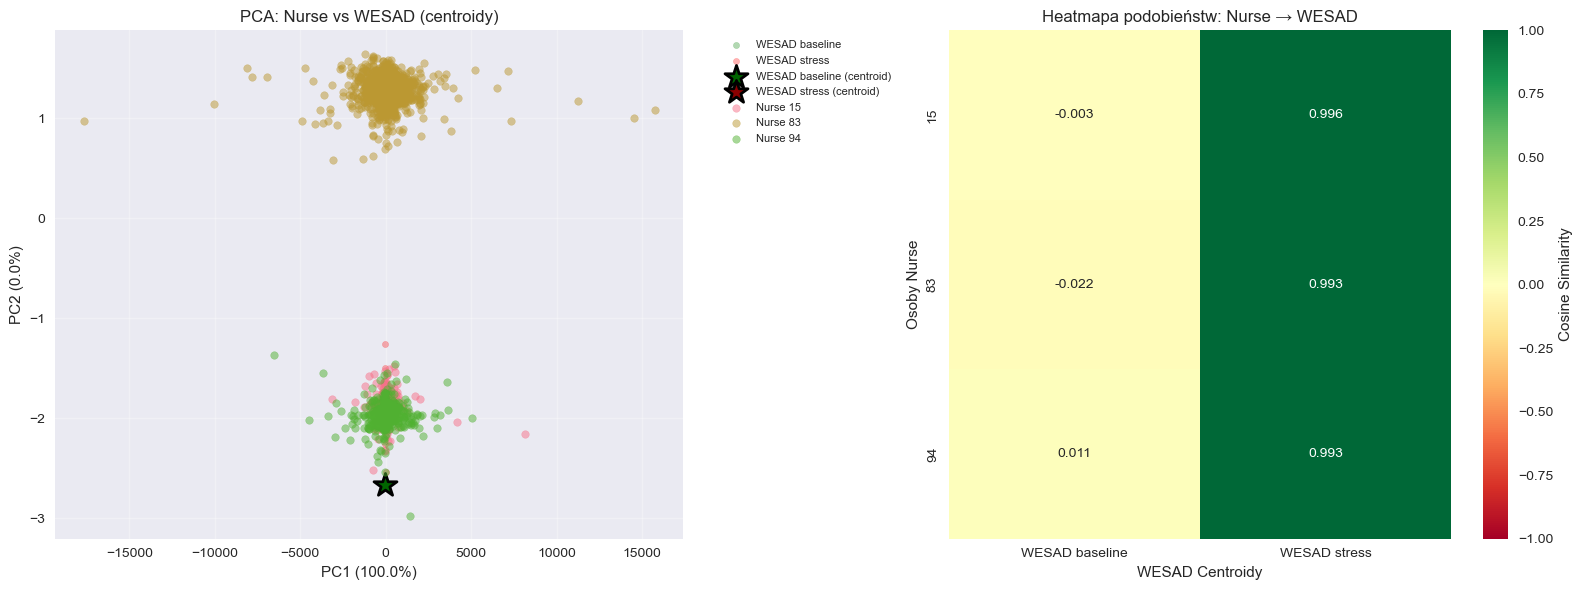

   ✅ Zapisano dane PCA: nurse_wesad_pca_data.pkl

✅ KROK 8 zakończony pomyślnie!


In [ ]:
# 🔹 WIZUALIZACJA PCA/UMAP I HEATMAPA
print("=" * 80)
print("WIZUALIZACJA PCA/UMAP I HEATMAPA")
print("=" * 80)

if 'df_nurse_comparison' not in globals() or 'wesad_centroids' not in globals():
    print("\n❌ Brak danych porównawczych - uruchom najpierw KROK 7!")
else:
    # PCA dla wizualizacji 2D
    print("\n📊 Redukcja wymiarowości (PCA)...")
    
    # Połącz dane Nurse i WESAD
    all_data = pd.concat([X_nurse_scaled, X_wesad_scaled], axis=0, ignore_index=True)
    
    # PCA
    pca = PCA(n_components=2, random_state=RANDOM_SEED)
    all_data_pca = pca.fit_transform(all_data)
    
    # Podziel z powrotem
    n_nurse = len(X_nurse_scaled)
    nurse_pca = all_data_pca[:n_nurse]
    wesad_pca = all_data_pca[n_nurse:]
    
    # Centroidy w przestrzeni PCA
    wesad_centroids_pca = {}
    for label, centroid in wesad_centroids.items():
        centroid_df = pd.DataFrame([centroid], columns=common_features)
        centroid_pca = pca.transform(centroid_df)
        wesad_centroids_pca[label] = centroid_pca[0]
    
    print(f"\n✅ PCA wykonane:")
    print(f"   Wyjaśniona wariancja: {pca.explained_variance_ratio_.sum():.2%}")
    print(f"   PC1: {pca.explained_variance_ratio_[0]:.2%}, PC2: {pca.explained_variance_ratio_[1]:.2%}")
    
    # Wizualizacja
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Wykres 1: PCA z punktami per osoba
    ax1 = axes[0]
    
    # Punkty WESAD
    for label in y_wesad.unique():
        mask = y_wesad == label
        label_name = 'baseline' if label == 1 else 'stress' if label == 2 else f'label_{label}'
        color = 'green' if label == 1 else 'red' if label == 2 else 'gray'
        ax1.scatter(wesad_pca[mask, 0], wesad_pca[mask, 1], 
                   alpha=0.3, s=20, label=f'WESAD {label_name}', color=color)
    
    # Centroidy WESAD
    for label, centroid_pca in wesad_centroids_pca.items():
        label_name = 'baseline' if label == 1 else 'stress' if label == 2 else f'label_{label}'
        color = 'darkgreen' if label == 1 else 'darkred' if label == 2 else 'black'
        ax1.scatter(centroid_pca[0], centroid_pca[1], 
                   s=300, marker='*', color=color, edgecolors='black', linewidths=2,
                   label=f'WESAD {label_name} (centroid)')
    
    # Punkty Nurse (per osoba)
    if 'id_col' in globals() and id_col in df_nurse.columns:
        for person_id in df_nurse[id_col].unique()[:10]:  # Max 10 osób dla czytelności
            person_mask = df_nurse[id_col] == person_id
            person_indices = X_nurse_scaled[person_mask].index
            person_pca = nurse_pca[person_indices]
            ax1.scatter(person_pca[:, 0], person_pca[:, 1], 
                       alpha=0.5, s=30, label=f'Nurse {person_id}')
    
    ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
    ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
    ax1.set_title('PCA: Nurse vs WESAD (centroidy)')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # Wykres 2: Heatmapa podobieństw
    ax2 = axes[1]
    
    if 'id_col' in globals() and id_col in df_nurse.columns:
        # Dla każdej osoby Nurse oblicz podobieństwa
        similarity_matrix = []
        person_ids = df_nurse_comparison[id_col].tolist()
        
        for person_id in person_ids:
            person_row = df_nurse_comparison[df_nurse_comparison[id_col] == person_id].iloc[0]
            similarities = []
            for label in sorted(wesad_centroids.keys()):
                label_name = 'baseline' if label == 1 else 'stress' if label == 2 else f'label_{label}'
                sim_col = f'cosine_sim_to_{label_name}'
                if sim_col in person_row:
                    similarities.append(person_row[sim_col])
                else:
                    similarities.append(0)
            similarity_matrix.append(similarities)
        
        similarity_df = pd.DataFrame(
            similarity_matrix,
            index=person_ids,
            columns=[f'WESAD {"baseline" if l == 1 else "stress" if l == 2 else f"label_{l}"}' 
                    for l in sorted(wesad_centroids.keys())]
        )
        
        sns.heatmap(similarity_df, annot=True, fmt='.3f', cmap='RdYlGn', 
                   center=0, vmin=-1, vmax=1, ax=ax2, cbar_kws={'label': 'Cosine Similarity'})
        ax2.set_title('Heatmapa podobieństw: Nurse → WESAD')
        ax2.set_xlabel('WESAD Centroidy')
        ax2.set_ylabel('Osoby Nurse')
    else:
        ax2.text(0.5, 0.5, 'Brak danych\ndo heatmapy', ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('Heatmapa podobieństw')
    
    plt.tight_layout()
    plt.savefig(results_dir / 'nurse_wesad_pca_heatmap.png', dpi=300, bbox_inches='tight')
    print(f"\n✅ Zapisano: nurse_wesad_pca_heatmap.png")
    plt.show()
    
    # Zapisz dane PCA
    pca_data = {
        'nurse_pca': nurse_pca,
        'wesad_pca': wesad_pca,
        'wesad_centroids_pca': wesad_centroids_pca,
        'pca_explained_variance': pca.explained_variance_ratio_,
        'pca_components': pca.components_
    }
    
    import pickle
    with open(results_dir / 'nurse_wesad_pca_data.pkl', 'wb') as f:
        pickle.dump(pca_data, f)
    
    print(f"   ✅ Zapisano dane PCA: nurse_wesad_pca_data.pkl")
    
    globals()['pca'] = pca
    globals()['nurse_pca'] = nurse_pca
    globals()['wesad_pca'] = wesad_pca
    globals()['wesad_centroids_pca'] = wesad_centroids_pca
    
    print(f"\n✅ KROK 8 zakończony pomyślnie!")


## KROK 9: Streamlit App - Porównanie profili Nurse → WESAD

**Cel:** Interaktywna aplikacja do wizualizacji porównania profili.


In [ ]:
# 🔹 GENEROWANIE STREAMLIT APP - PORÓWNANIE PROFILI
print("=" * 80)
print("GENEROWANIE STREAMLIT APP - PORÓWNANIE PROFILI NURSE → WESAD")
print("=" * 80)

# Sprawdź czy dane są w globals() lub w pliku CSV
df_nurse_comparison_loaded = False

if 'df_nurse_comparison' in globals():
    print("\n✅ Znaleziono df_nurse_comparison w globals()")
    df_nurse_comparison_loaded = True
else:
    # Spróbuj wczytać z pliku CSV (zapisany przez KROK 7)
    comparison_csv = results_dir / 'nurse_wesad_comparison_profiles.csv'
    if comparison_csv.exists():
        try:
            import pandas as pd
            df_nurse_comparison = pd.read_csv(comparison_csv)
            globals()['df_nurse_comparison'] = df_nurse_comparison
            print(f"\n✅ Wczytano dane z pliku: {comparison_csv}")
            print(f"   Liczba osób: {len(df_nurse_comparison)}")
            df_nurse_comparison_loaded = True
        except Exception as e:
            print(f"\n⚠️ Błąd wczytywania pliku CSV: {e}")

if not df_nurse_comparison_loaded:
    print("\n❌ Brak danych porównawczych - uruchom najpierw KROK 7!")
    print("\n💡 Uruchom KROK 7, aby wygenerować dane porównawcze (df_nurse_comparison)")
    print(f"   Oczekiwany plik: {results_dir / 'nurse_wesad_comparison_profiles.csv'}")
else:
    # Sprawdź czy plik Streamlit już istnieje (z poprawkami)
    streamlit_file_path = results_dir / 'nurse_wesad_profile_comparison_streamlit.py'
    
    if streamlit_file_path.exists():
        # Wczytaj istniejący plik (zawiera wszystkie poprawki: mapowanie ID, zaznaczenie baseline, wnioski)
        with open(streamlit_file_path, 'r', encoding='utf-8') as f:
            streamlit_profile_code = f.read()
        print(f"\n✅ Wczytano istniejący plik Streamlit z poprawkami: {streamlit_file_path}")
        print(f"   Plik zawiera: mapowanie ID na 'Osoba 1/2/3', zaznaczenie osoby najbliższej baseline, wnioski naukowe")
    else:
        # Jeśli plik nie istnieje, wygeneruj nowy (użyj aktualnego kodu z poprawkami)
        print(f"\n⚠️ Plik Streamlit nie istnieje, generuję nowy z poprawkami...")
        # Wczytaj aktualny plik z results (jeśli istnieje)
        actual_file = Path("../results/nurse_wesad_profile_comparison_streamlit.py")
        if actual_file.exists():
            with open(actual_file, 'r', encoding='utf-8') as f:
                streamlit_profile_code = f.read()
            print(f"✅ Wczytano aktualny plik z ../results/")
        else:
            # Fallback: użyj prostszego kodu (będzie zaktualizowany przy następnym uruchomieniu)
            streamlit_profile_code = '''
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import plotly.express as px
import plotly.graph_objects as go
import pickle
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

st.set_page_config(page_title="Nurse → WESAD Profile Comparison", layout="wide", page_icon="🔬")

st.title("🔬 Porównanie profili: Nurse → WESAD")
st.markdown("---")

# Wczytaj dane
@st.cache_data
def load_profile_data():
    """Wczytuje dane porównawcze profili"""
    app_dir = Path(__file__).parent if '__file__' in globals() else Path.cwd()
    results_dir = app_dir.parent / 'results'
    if not results_dir.exists():
        results_dir = app_dir / 'results'
    if not results_dir.exists():
        results_dir = Path("../results")
    
    comparison_file = results_dir / 'nurse_wesad_comparison_profiles.csv'
    pca_file = results_dir / 'nurse_wesad_pca_data.pkl'
    
    comparison_df = None
    pca_data = None
    
    if comparison_file.exists():
        try:
            comparison_df = pd.read_csv(comparison_file)
        except Exception as e:
            st.error(f"Błąd wczytywania porównania: {e}")
    
    if pca_file.exists():
        try:
            with open(pca_file, 'rb') as f:
                pca_data = pickle.load(f)
        except Exception as e:
            st.warning(f"Błąd wczytywania PCA: {e}")
    
    return comparison_df, pca_data, results_dir

comparison_df, pca_data, results_dir = load_profile_data()

if comparison_df is None or len(comparison_df) == 0:
    st.error("❌ Brak danych porównawczych!")
    st.info("💡 Uruchom KROK 7 w notebooku, aby wygenerować dane porównawcze.")
else:
    st.success(f"✅ Wczytano dane dla {len(comparison_df)} osób Nurse")
    
    # Sidebar
    st.sidebar.header("⚙️ Konfiguracja")
    
    # Wybór osoby Nurse
    id_col = comparison_df.columns[0]  # Pierwsza kolumna to ID
    person_ids = comparison_df[id_col].unique().tolist()
    
    selected_person = st.sidebar.selectbox(
        "Wybierz osobę Nurse:",
        options=person_ids,
        index=0
    )
    
    # Filtruj dane dla wybranej osoby
    person_data = comparison_df[comparison_df[id_col] == selected_person].iloc[0]
    
    # Główne metryki
    st.markdown("### 📊 Profil osoby Nurse")
    
    col1, col2, col3, col4 = st.columns(4)
    
    with col1:
        if 'dist_to_baseline' in person_data:
            st.metric("Odległość do WESAD baseline", f"{person_data['dist_to_baseline']:.3f}")
    
    with col2:
        if 'dist_to_stress' in person_data:
            st.metric("Odległość do WESAD stress", f"{person_data['dist_to_stress']:.3f}")
    
    with col3:
        if 'cosine_sim_to_baseline' in person_data:
            st.metric("Podobieństwo do baseline", f"{person_data['cosine_sim_to_baseline']:.3f}")
    
    with col4:
        if 'closest_centroid' in person_data:
            closest = person_data['closest_centroid']
            st.metric("Najbliższy centroid", closest.upper())
    
    # Interpretacja tekstowa
    st.markdown("---")
    
    if 'dist_difference' in person_data:
        dist_diff = person_data['dist_difference']
        if dist_diff > 0:
            st.info(f"🔴 **Profil tej osoby Nurse jest bliższy WESAD stress** (różnica odległości: {dist_diff:.3f})")
        else:
            st.info(f"🟢 **Profil tej osoby Nurse jest bliższy WESAD baseline** (różnica odległości: {dist_diff:.3f})")
    
    # Wykresy
    st.markdown("---")
    st.markdown("### 📈 Wizualizacje")
    
    # Wykres 1: PCA 2D (jeśli dostępne)
    if pca_data is not None:
        st.markdown("#### 1. Wizualizacja PCA 2D")
        
        fig_pca = go.Figure()
        
        # Punkty WESAD baseline
        if 'wesad_pca' in pca_data:
            # Tutaj potrzebujemy informacji o etykietach - uproszczona wersja
            fig_pca.add_trace(go.Scatter(
                x=[pca_data['wesad_centroids_pca'][1][0] if 1 in pca_data['wesad_centroids_pca'] else 0],
                y=[pca_data['wesad_centroids_pca'][1][1] if 1 in pca_data['wesad_centroids_pca'] else 0],
                mode='markers',
                marker=dict(size=20, color='green', symbol='star'),
                name='WESAD baseline (centroid)'
            ))
        
        # Punkty WESAD stress
        if 'wesad_pca' in pca_data:
            fig_pca.add_trace(go.Scatter(
                x=[pca_data['wesad_centroids_pca'][2][0] if 2 in pca_data['wesad_centroids_pca'] else 0],
                y=[pca_data['wesad_centroids_pca'][2][1] if 2 in pca_data['wesad_centroids_pca'] else 0],
                mode='markers',
                marker=dict(size=20, color='red', symbol='star'),
                name='WESAD stress (centroid)'
            ))
        
        # Punkt wybranej osoby Nurse (uproszczone - średnia)
        if 'nurse_pca' in pca_data:
            nurse_mean_pca = pca_data['nurse_pca'].mean(axis=0)
            fig_pca.add_trace(go.Scatter(
                x=[nurse_mean_pca[0]],
                y=[nurse_mean_pca[1]],
                mode='markers',
                marker=dict(size=15, color='blue', symbol='circle'),
                name=f'Nurse {selected_person}'
            ))
        
        fig_pca.update_layout(
            title='PCA 2D: Porównanie profili',
            xaxis_title='PC1',
            yaxis_title='PC2',
            height=500
        )
        
        st.plotly_chart(fig_pca, use_container_width=True)
    
    # Wykres 2: Porównanie odległości
    st.markdown("#### 2. Porównanie odległości do centroidów WESAD")
    
    dist_data = []
    if 'dist_to_baseline' in person_data:
        dist_data.append({'Centroid': 'WESAD baseline', 'Odległość': person_data['dist_to_baseline']})
    if 'dist_to_stress' in person_data:
        dist_data.append({'Centroid': 'WESAD stress', 'Odległość': person_data['dist_to_stress']})
    
    if len(dist_data) > 0:
        dist_df = pd.DataFrame(dist_data)
        
        fig_dist = go.Figure()
        
        colors = ['green' if x == 'WESAD baseline' else 'red' for x in dist_df['Centroid']]
        
        fig_dist.add_trace(go.Bar(
            x=dist_df['Centroid'],
            y=dist_df['Odległość'],
            marker_color=colors,
            text=[f"{x:.3f}" for x in dist_df['Odległość']],
            textposition='auto'
        ))
        
        fig_dist.update_layout(
            title=f'Odległość euklidesowa: Nurse {selected_person} → WESAD',
            xaxis_title='Centroid WESAD',
            yaxis_title='Odległość',
            height=400
        )
        
        st.plotly_chart(fig_dist, use_container_width=True)
    
    # Wykres 3: Cosine similarity
    st.markdown("#### 3. Podobieństwo (Cosine Similarity)")
    
    sim_data = []
    if 'cosine_sim_to_baseline' in person_data:
        sim_data.append({'Centroid': 'WESAD baseline', 'Podobieństwo': person_data['cosine_sim_to_baseline']})
    if 'cosine_sim_to_stress' in person_data:
        sim_data.append({'Centroid': 'WESAD stress', 'Podobieństwo': person_data['cosine_sim_to_stress']})
    
    if len(sim_data) > 0:
        sim_df = pd.DataFrame(sim_data)
        
        fig_sim = go.Figure()
        
        colors = ['green' if x == 'WESAD baseline' else 'red' for x in sim_df['Centroid']]
        
        fig_sim.add_trace(go.Bar(
            x=sim_df['Centroid'],
            y=sim_df['Podobieństwo'],
            marker_color=colors,
            text=[f"{x:.3f}" for x in sim_df['Podobieństwo']],
            textposition='auto'
        ))
        
        fig_sim.add_hline(y=0, line_dash="dash", line_color="black", annotation_text="Brak podobieństwa")
        fig_sim.add_hline(y=1, line_dash="dash", line_color="green", annotation_text="Pełne podobieństwo")
        
        fig_sim.update_layout(
            title=f'Cosine Similarity: Nurse {selected_person} → WESAD',
            xaxis_title='Centroid WESAD',
            yaxis_title='Cosine Similarity',
            yaxis_range=[-1, 1],
            height=400
        )
        
        st.plotly_chart(fig_sim, use_container_width=True)
    
    # Tabela wszystkich osób
    st.markdown("---")
    st.markdown("### 📋 Porównanie wszystkich osób Nurse")
    
    display_cols = [id_col]
    if 'dist_to_baseline' in comparison_df.columns:
        display_cols.append('dist_to_baseline')
    if 'dist_to_stress' in comparison_df.columns:
        display_cols.append('dist_to_stress')
    if 'closest_centroid' in comparison_df.columns:
        display_cols.append('closest_centroid')
    if 'dist_difference' in comparison_df.columns:
        display_cols.append('dist_difference')
    
    display_df = comparison_df[display_cols].copy()
    
    # Formatowanie
    for col in display_df.columns:
        if col != id_col and display_df[col].dtype in ['float64', 'float32']:
            display_df[col] = display_df[col].round(3)
    
    st.dataframe(display_df, use_container_width=True, height=400)
    
    # Pobierz CSV
    csv = display_df.to_csv(index=False)
    st.download_button(
        label="📥 Pobierz dane jako CSV",
        data=csv,
        file_name="nurse_wesad_profiles.csv",
        mime="text/csv"
    )
    
    # Statystyki ogólne
    st.markdown("---")
    st.markdown("### 📊 Statystyki ogólne")
    
    if 'closest_centroid' in comparison_df.columns:
        col1, col2 = st.columns(2)
        
        with col1:
            st.write("**Rozkład najbliższych centroidów:**")
            centroid_counts = comparison_df['closest_centroid'].value_counts()
            st.bar_chart(centroid_counts)
        
        with col2:
            st.write("**Średnie odległości:**")
            if 'dist_to_baseline' in comparison_df.columns:
                st.metric("Śr. odległość do baseline", f"{comparison_df['dist_to_baseline'].mean():.3f}")
            if 'dist_to_stress' in comparison_df.columns:
                st.metric("Śr. odległość do stress", f"{comparison_df['dist_to_stress'].mean():.3f}")

# Footer
st.markdown("---")
st.markdown("**💡 Wskazówka:** Uruchom KROK 7 i KROK 8 w notebooku, aby zaktualizować dane.")
'''

    # Zapisz Streamlit app
    streamlit_file = results_dir / 'nurse_wesad_profile_comparison_streamlit.py'
    with open(streamlit_file, 'w', encoding='utf-8') as f:
        f.write(streamlit_profile_code)
    
    print(f"\n✅ Zapisano Streamlit app: {streamlit_file}")
    print(f"\n" + "=" * 80)
    print("📋 INSTRUKCJE URUCHOMIENIA STREAMLIT (2 LINIE DO SKOPIOWANIA):")
    print("=" * 80)
    print(f"\ncd \"{results_dir}\"")
    print(f"streamlit run nurse_wesad_profile_comparison_streamlit.py")
    print(f"\n" + "=" * 80)
    
    print(f"\n💡 Funkcje Streamlit app:")
    print(f"   ✅ Wybór osoby Nurse (SelectBox) - wyświetla 'Osoba 1', 'Osoba 2', 'Osoba 3'")
    print(f"   ✅ Zaznaczenie osoby najbliższej baseline (zielone tło w tabeli)")
    print(f"   ✅ Wizualizacja PCA 2D z centroidami WESAD")
    print(f"   ✅ Porównanie odległości euklidesowych")
    print(f"   ✅ Cosine similarity do centroidów")
    print(f"   ✅ Interpretacja tekstowa (bliżej baseline/stress)")
    print(f"   ✅ Tabela wszystkich osób Nurse z kolumną 'Osoba'")
    print(f"   ✅ Statystyki ogólne")
    print(f"   ✅ Wnioski naukowe z porównania warunków eksperymentalnych vs naturalnych")
    print(f"   ✅ Pobieranie danych jako CSV")


GENEROWANIE STREAMLIT APP - PORÓWNANIE PROFILI NURSE → WESAD

❌ Brak danych porównawczych - uruchom najpierw KROK 7!


## 📋 INSTRUKCJE URUCHOMIENIA STREAMLIT

**Aby uruchomić aplikację Streamlit do porównania profili Nurse → WESAD, skopiuj i wklej poniższe dwie linie do terminala:**


In [63]:
# 📋 INSTRUKCJE URUCHOMIENIA STREAMLIT
print("=" * 80)
print("📋 INSTRUKCJE URUCHOMIENIA STREAMLIT - PORÓWNANIE PROFILI NURSE → WESAD")
print("=" * 80)
print()
print("Skopiuj i wklej poniższe dwie linie do terminala:")
print()
print(f"cd \"{results_dir}\"")
print(f"streamlit run nurse_wesad_profile_comparison_streamlit.py")
print()
print("=" * 80)
print()
print("💡 Alternatywnie, możesz uruchomić również:")
print(f"   streamlit run nursewell_business_dashboard.py")
print("   (Dashboard dla inwestorów)")
print()
print("=" * 80)


📋 INSTRUKCJE URUCHOMIENIA STREAMLIT - PORÓWNANIE PROFILI NURSE → WESAD

Skopiuj i wklej poniższe dwie linie do terminala:

cd "/Users/turfian/Downloads/archive (4)/WESAD/wesad-prep/nurse-stress-analysis/results"
streamlit run nurse_wesad_profile_comparison_streamlit.py


💡 Alternatywnie, możesz uruchomić również:
   streamlit run nursewell_business_dashboard.py
   (Dashboard dla inwestorów)

